# Modules, colors, and functions

### Remove scroll from figures

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Extend the size of the Window

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Load Modules

In [3]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy import convolution as conv
from astropy.time import Time
import datetime
import glob
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
from matplotlib import cm
import numpy as np
import pandas as pd
from pprint import pprint
import scipy as sp
from scipy.interpolate import griddata
from scipy import sparse, signal, stats
# import sunpy.cm as cm
import sunpy.map
import sunpy.physics.differential_rotation as dr
import torch.nn.functional as F

import sys, os

os.environ["CUDA_VISIBLE_DEVICES"]=""

sys.path.append("../../../")
from source.pipeline.model_manager import BaseScaler
from source.pipeline.models.highresnet import HighResNet
from source.pipeline.models.highresnet_rprc import HighResNet_RPRC
from source.pipeline.losses.baseline_loss import MSELoss, L1Loss
from source.pipeline.entropy import Entropy
from source.utils import create_hist_bins

from source.pipeline.metrics_denoised_hist import DenoisedHistogram

from source.patch_stitch import get_patch
from source.patch_stitch import get_img_from_patch
from source.multiframe import register

from skimage.transform import resize

import torch
import torch.nn as nn
import yaml

%matplotlib inline

### Load and interface with Google Cloud Storage

In [4]:
# Imports the Google Cloud client library
from google.cloud import storage

# Instantiates a client
client = storage.Client()

### Remove Warnings and Define Color Defaults

You can switch colormaps between *hmimag* (*seismic*) if you want to focus on the *weak* (*strong*) magnetic features.

In [5]:
# Remove Warnings
# import warnings
# warnings.filterwarnings('ignore')

# Color Axis limits
vmin = -2000
vmax = 2000

# Color definitions
ClrS = (0.74, 0.00, 0.00)
ClrN = (0.20, 0.56, 1.00)

Clr = [(0.00, 0.00, 0.00),
      (0.31, 0.24, 0.00),
      (0.43, 0.16, 0.49),
      (0.32, 0.70, 0.30),
      (0.45, 0.70, 0.90),
      (1.00, 0.82, 0.67)]

# Colormap Definition
current_cmap = plt.cm.get_cmap('hmimag')
# current_cmap = plt.cm.get_cmap('seismic')
current_cmap.set_bad(color='black')

device = torch.device('cpu')




# Load CSV

In [6]:
# # # # # ## Bicubic
# suffix = 'test'
# run = 'to-ml-register-template_20200325003952_BiCubic_MSELoss_256_0.0001_Bicubic'
# suffix = 'validate'
# run = 'to-ml-register-template_20200320010145_BiCubic_MSELoss_256_0.0001_Bicubic'
# runi = '-'
# epoch = 'epoch_19'
# config_path = '../../../configs/eval/MDI_HMI_bicubic.yml'
# label = 'Bicubic_' + suffix
# title = 'Bicubic\n.'
# Ylabels = False


# ## MSE without alignment
# suffix = 'test'
# run = 'to-ml-register-nodiff_20200325003948_HighRes_net_MSELoss_64_0.0001_MSE_HRN_NA'
# suffix = 'validate'
# run = 'to-ml-register-nodiff_20200324214011_HighRes_net_MSELoss_64_0.0001_MSE_HRN_NA'
# runi = 'to-ml_20200205143318_HighRes_net_MSELoss_64_0.0001_MSELoss'
# epoch = 'epoch_19'
# config_path = '../../../configs/experiments/MDI_HMI_1_P_MSE/MDI_HMI_1_P_highresnet_mse_NA.yml'
# label = 'MSE_dec_not_aligned'
# title = 'MSE\nNot Aligned'
# Ylabels = False







# # # # ## Histogram loss with convection rescale and new data
# suffix = 'test'
# run = 'to-ml-register-template_20200325162345_HighResNet_RPRC_HistLoss_64_0.0001_HistLoss_RPRC_temp'
# # suffix = 'validate'
# # run = 'to-ml-register-template_20200325135816_HighResNet_RPRC_HistLoss_64_0.0001_HistLoss_RPRC_temp'
# runi = 'to-ml-register-template_20200218190822_HighResNet_RPRC_HistLoss_64_0.0001_HistLoss_RPRC_temp'
# epoch = 'epoch_19'
# config_path = '../../../configs/experiments/MDI_HMI_Hist/MDI_HMI_1_P_highresnet_RPRC_hist_temp.yml'
# label = 'Hist_res_conv_temp'
# title = 'MSE\n+Hist'
# Ylabels = False


# # # # ## SSIM loss with new data
# suffix = 'test'
# run = 'to-ml-register-template_20200325162355_HighRes_net_RP_SSIMLoss_64_0.0001_SSIMLoss_temp'
# # suffix = 'validate'
# # run  = 'to-ml-register-template_20200325135928_HighRes_net_RP_SSIMLoss_64_0.0001_SSIMLoss_temp'
# runi = 'to-ml-register-template_20200216025914_HighRes_net_RP_SSIMLoss_64_0.0001_SSIMLoss_temp'
# epoch = 'epoch_17'
# config_path = '../../../configs/experiments/MDI_HMI_SSIM/MDI_HMI_HRN_RP_SSIM_temp.yml'
# label = 'SSIM_dec_temp'
# title = 'MSE\n+SSIM'
# Ylabels = False


# # # # ## Gradient loss with convection rescale and new data
# suffix = 'test'
# run = 'to-ml-mdi-new_20210227143023_HighResNet_RPRC_GradientLoss_64_0.0001_Grad_RPRC_temp'
# # suffix = 'validate'
# # run = 'to-ml-register-template_20200325140017_HighResNet_RPRC_GradientLoss_64_0.0001_Grad_RPRC_temp'
# runi = 'to-ml-register-template_20200216195335_HighResNet_RPRC_GradientLoss_64_0.0001_Grad_RPRC_temp'
# epoch = 'epoch_19'
# config_path = '../../../configs/experiments/MDI_HMI_1_P_GradientLoss/MDI_HMI_1_P_highresnet_RPRC_gradient_temp.yml'
# label = 'Grad_res_conv_temp'
# title = 'MSE\n+Grad'
# Ylabels = False


# # # # # ## SSIM + Hist
# suffix = 'test'
# run = 'to-ml-register-template_20200326002715_HighResNet_RPRC_SSIMHistLoss_64_0.0001_SSIMHistLoss_temp'
# # suffix = 'validate'
# # run = 'to-ml-register-template_20200325213446_HighResNet_RPRC_SSIMHistLoss_64_0.0001_SSIMHistLoss_temp'
# runi = 'to-ml-register-template_20200217223037_HighResNet_RPRC_SSIMHistLoss_64_0.0001_SSIMHistLoss_temp'
# epoch = 'epoch_19'
# config_path = '../../../configs/experiments/MDI_HMI_SSIMHistLoss/MDI_HMI_1_P_highresnet_RPRC_SSIMhist_temp.yml'
# label = 'SSIM_Hist_res_conv_temp'
# title = 'MSE + SSIM\n+Hist'
# Ylabels = False


# # # # ## Hist + Grad
# suffix = 'test'
# run = 'to-ml-mdi-new_20210227235741_HighResNet_RPRC_GradHistLoss_64_0.0001_GradHistLoss_temp'
# # suffix = 'validate'
# # run = 'to-ml-register-template_20200325213534_HighResNet_RPRC_GradHistLoss_64_0.0001_GradHistLoss_temp'
# runi = 'to-ml-register-template_20200217224420_HighResNet_RPRC_GradHistLoss_64_0.0001_GradHistLoss_temp'
# epoch = 'epoch_19'
# config_path = '../../../configs/experiments/MDI_HMI_1_P_GradHistLoss/MDI_HMI_1_P_highresnet_RPRC_Gradhist_temp.yml'
# label = 'Hist_Grad_res_conv_temp'
# title = 'MSE + Grad\n+Hist'
# Ylabels = False


# # # # ## SSIM + Grad
# suffix = 'test'
# run = 'to-ml-register-template_20200326002647_HighResNet_RPRC_SSIMGradLoss_64_0.0001_SSIMGradLoss_temp'
# # suffix = 'validate'
# # run = 'to-ml-register-template_20200325213713_HighResNet_RPRC_SSIMGradLoss_64_0.0001_SSIMGradLoss_temp'
# runi = 'to-ml-register-template_20200217230224_HighResNet_RPRC_SSIMGradLoss_64_0.0001_SSIMGradLoss_temp'
# epoch = 'epoch_19'
# config_path = '../../../configs/experiments/MDI_HMI_SSIM_Grad/MDI_HMI_1_P_highresnet_RPRC_SSIMGrad_temp.yml'
# label = 'SSIM_Grad_res_conv_temp'
# title = 'MSE + Grad\n+SSIM'
# Ylabels = False

########## BEST
# # # # ## SSIM + Hist + Grad
# suffix = 'test'
# run = 'to-ml-register-template_20200326174635_HighResNet_RPRCDO_SSIMGradHistLoss_64_0.0001_SSIMGradHistLoss_dropout'
# # suffix = 'validate'
# # run = 'to-ml-register-template_20200326151847_HighResNet_RPRCDO_SSIMGradHistLoss_64_0.0001_SSIMGradHistLoss_dropout'
# runi = 'to-ml-register-template_20200312194454_HighResNet_RPRCDO_SSIMGradHistLoss_64_0.0001_SSIMGradHistLoss_dropout'
# epoch = 'epoch_19'
# config_path = '../../../configs/experiments/MDI_HMI_SSIM_Grad_Hist/MDI_HMI_1_P_highresnet_RPRC_SSIMGradhist_temp_G5.yml'
# label = 'SSIM_Hist_Grad_low_' + suffix
# title = 'MSE + SSIM\n+ HIST + Grad'
# Ylabels = True




# # # # ## SSIM + Hist + Grad with JSOC data
# suffix = 'test'
# run = 'to-ml-mdi-new_20210228141237_HighResNet_RPRCDO_SSIMGradHistLoss_64_0.0001_SSIMGradHistLoss_dropout_jsoc_rp'
# runi = 'to-ml-mdi-new_20200501145532_HighResNet_RPRCDO_SSIMGradHistLoss_64_0.0001_SSIMGradHistLoss_dropout_jsoc'
# epoch = 'epoch_18'
# config_path = '../../../configs/experiments/MDI_HMI_SSIM_Grad_Hist/MDI_HMI_1_P_highresnet_RPRC_SSIMGradhist_temp_G5.yml'
# label = 'SSIM_Hist_Grad_low_jsoc' + suffix
# title = 'MSE + SSIM\n+ HIST + Grad'
# Ylabels = True


# ####  Reproject
# suffix = 'test'
# run = 'to-ml-reproject_20201021165918_HighResNet_RPRCDO_SSIMGradHistLoss_64_0.0001_SSIMGradHistLoss_DO_jsoc_RP_Neg'
# runi = 'to-ml-reproject_20201017075415_HighResNet_RPRCDO_SSIMGradHistLoss_64_0.0001_SSIMGradHistLoss_DO_jsoc_RP'
# epoch = 'epoch_19'
# config_path = '../../../configs/configs/experiments/MDI_HMI_SSIM_Grad_Hist/MDI_HMI_1_P_HR_RPRC_SSIMGradhist_G5_jsoc_RP.yml'
# label = 'SSIM_Hist_Grad_RP' + suffix
# title = 'MSE + SSIM\n+ HIST + Grad + RP'
# Ylabels = True


# # # ####  Polarity symmetric
# suffix = 'test'
# run = 'to-ml-reproject_20210214011640_HighResNet_RPRCDO_SSIMGradHistLoss_64_0.0001_SSIMGradHistLoss_DO_jsoc_RP_Neg'
# # runi = 'to-ml-reproject_20201020035600_HighResNet_RPRCDO_SSIMGradHistLoss_64_0.0001_SSIMGradHistLoss_DO_jsoc_RP_Neg'
# # epoch = 'epoch_19'
# config_path = '../../../configs/experiments/MDI_HMI_SSIM_Grad_Hist/MDI_HMI_1_P_HR_RPRC_SSIMGradhist_G5_jsoc_RP.yml'
# label = 'SSIM_Hist_Grad_RP' + suffix
# title = 'MSE + SSIM\n+ HIST + Grad + RP'
# Ylabels = True
# # Cal = 1.3

# # # 2X
# suffix = 'test'
# run = 'to-ml-reproject_20210214040247_HighResNet_RPRCDO_SSIMGradHistLoss_64_0.0001_SSIMGradHistLoss_DO_jsoc_RP2'
# # runi = 'to-ml-reproject_20210209000430_HighResNet_RPRCDO_SSIMGradHistLoss_64_0.0001_SSIMGradHistLoss_DO_jsoc_RP2'
# # epoch = 'epoch_18'
# config_path = '../../../configs/experiments/MDI_HMI_SSIM_Grad_Hist/MDI_HMI_1_P_HR_RPRC_SSIMGradhist_G5_jsoc_RP_D2.yml'
# label = 'SSIM_Hist_Grad_RP_D2' + suffix
# title = 'MSE + SSIM\n+ HIST + Grad + RP + D2'
# Ylabels = True
# Cal = 1.07

# # # 1X
# suffix = 'test'
# run = 'to-ml-reproject_20210214170617_HighResNet_RPRCDO_SSIMGradHistLoss_64_0.0001_SSIMGradHistLoss_DO_jsoc_RP1'
# # runi = 'to-ml-reproject_20210207214138_HighResNet_RPRCDO_SSIMGradHistLoss_64_0.0001_SSIMGradHistLoss_DO_jsoc_RP1'
# # epoch = 'epoch_19'
# config_path = '../../../configs/experiments/MDI_HMI_SSIM_Grad_Hist/MDI_HMI_1_P_HR_RPRC_SSIMGradhist_G5_jsoc_RP_D1.yml'
# label = 'SSIM_Hist_Grad_RP' + suffix
# title = 'MSE + SSIM\n+ HIST + Grad + RP'
Ylabels = True




# # # # # # ## SSIM + Hist + Grad  WN
# suffix = 'validate'
# run  = 'to-ml-register-template_20200401133453_HighResNet_RPRCDOWN_SSIMGradHistLoss_64_0.0001_SSIMGradHistLoss_dropout'
# runi = 'to-ml-register-template_20200330161129_HighResNet_RPRCDOWN_SSIMGradHistLoss_64_0.0001_SSIMGradHistLoss_WN'
# epoch = 'epoch_19'
# config_path = '../../../configs/experiments/MDI_HMI_SSIM_Grad_Hist/MDI_HMI_1_P_highresnet_RPRCWN_SSIMGradhist_temp_G5.yml'
# label = 'SSIM_Hist_Grad_low_WN'
# title = 'WMSE + SSIM\n+ HIST + Grad'
# Ylabels = False


# # # # # ## SSIM + Hist + Grad  WNPS
# suffix = 'test'
# # run = 'to-ml-register-template_20200402231333_HighResNet_RPRCDOWNPS_SSIMGradHistLoss_64_0.0001_SSIMGradHistLoss_WNPS'
# suffix = 'validate'
# run = 'to-ml-register-template_20200402032453_HighResNet_RPRCDOWNPS_SSIMGradHistLoss_64_0.0001_SSIMGradHistLoss_WNPS'
# # runi = 'to-ml-register-template_20200331133226_HighResNet_RPRCDOWNPS_SSIMGradHistLoss_64_0.0001_SSIMGradHistLoss_WNPS'
# epoch = 'epoch_17'
# config_path = '../../../configs/experiments/MDI_HMI_SSIM_Grad_Hist/MDI_HMI_1_P_highresnet_RPRCWNPS_SSIMGradhist_temp_G5.yml'
# label = 'SSIM_Hist_Grad_low_PSWN'
# title = 'WPMSE + SSIM\n+ HIST + Grad'
# Ylabels = False


######################################### GONG

# # # # ## Bicubic
# suffix = 'test'
# run = 'to-ml-temp-gong_20200327120442_BiCubic_MSELoss_256_0.0001_GONGBicubic'
# suffix = 'validate'
# run = 'to-ml-temp-gong_20200326151255_BiCubic_MSELoss_256_0.0001_GONGBicubic'
# runi = '-'
# epoch = 'epoch_19'
# config_path = '../../../configs/eval/GONG_HMI_bicubic.yml'
# label = 'GONG_Bicubic_' + suffix
# title = 'Bicubic\n.'
# Ylabels = True

# # # # MSE
# suffix = 'test'
# run = 'to-ml-temp-gong_20200327120457_HighResNet_RPRC_MSELoss_64_0.0001_MSE_GONG'
# suffix = 'validate'
# run = 'to-ml-temp-gong_20200326152039_HighResNet_RPRC_MSELoss_64_0.0001_MSE_GONG'
# # runi = 'to-ml-temp-gong_20200304175516_HighResNet_RPRC_MSELoss_64_0.0001_MSE_GONG'
# # epoch = 'epoch_8'
# # config_path = '../../../configs/experiments/GONG_HMI_1_P/GONG_HMI_highresnet_mse_rprc.yml'
# label = 'GONG_MSE'
# title = 'MSE\n.'
# Ylabels = False


# # # MSE + Grad
# suffix = 'test'
# run = 'to-ml-temp-gong_20200327120511_HighResNet_RPRC_GradientLoss_256_0.0001_Grad_RPRC_temp'
# suffix = 'validate'
# run = 'to-ml-temp-gong_20200326152306_HighResNet_RPRC_GradientLoss_256_0.0001_Grad_RPRC_temp'
# # runi = 'to-ml-temp-gong_20200305011745_HighResNet_RPRC_GradientLoss_256_0.0001_Grad_RPRC_temp'
# # epoch = 'epoch_13'
# # config_path = '../../../configs/experiments/GONG_HMI_1_P/GONG_HMI_HRN_RPRC_gradient_temp.yml'
# label = 'GONG_Grad'
# title = 'MSE\n+Grad'
# Ylabels = False


# # # MSE + Hist
# suffix = 'test'
# run = 'to-ml-temp-gong_20200327142251_HighResNet_RPRC_HistLoss_256_0.0001_HistLoss_RPRC_temp'
# suffix = 'validate'
# run = 'to-ml-temp-gong_20200326230648_HighResNet_RPRC_HistLoss_256_0.0001_HistLoss_RPRC_temp'
# # runi = 'to-ml-temp-gong_20200306005542_HighResNet_RPRC_HistLoss_128_0.0001_HistLoss_RPRC_temp'
# # epoch = 'epoch_8'
# # config_path = '../../../configs/experiments/GONG_HMI_1_P/GONG_HMI_HRN_RPRC_hist.yml'
# label = 'GONG_Hist'
# title = 'MSE\n+Hist'
# Ylabels = False

# # # # MSE + SSIM
# suffix = 'test'
# run = 'to-ml-temp-gong_20200329133109_HighResNet_RPRC_SSIMLoss_256_0.0001_GONG_SSIM_RPRC'
# suffix = 'validate'
# run  = 'to-ml-temp-gong_20200328223012_HighResNet_RPRC_SSIMLoss_256_0.0001_GONG_SSIM_RPRC'
# # runi = 'to-ml-temp-gong_20200305011742_HighResNet_RPRC_SSIMLoss_256_0.0001_GONG_SSIM_RPRC'
# # epoch = 'epoch_8'
# # config_path = '../../../configs/experiments/GONG_HMI_1_P/GONG_HMI_HRN_RPRC_SSIM.yml'
# label = 'GONG_SSIM'
# title = 'MSE\n+SSIM'
# Ylabels = False


# # # # MSE + SSIM + Hist
# suffix = 'test'
# run = 'to-ml-temp-gong_20200329133122_HighResNet_RPRCDO_SSIMHistLoss_128_0.0001_SSIMHistLoss_temp'
# suffix = 'validate'
# run = 'to-ml-temp-gong_20200328223117_HighResNet_RPRCDO_SSIMHistLoss_128_0.0001_SSIMHistLoss_temp'
# # run = 'to-ml-temp-gong_20200311191125_HighResNet_RPRCDO_SSIMHistLoss_128_0.0001_SSIMHistLoss_temp'
# # epoch = 'epoch_10'
# # config_path = '../../../configs/experiments/GONG_HMI_1_P/GONG_HMI_highresnet_RPRC_SSIMhist_temp.yml'
# label = 'GONG_SSIM_Hist'
# title = 'MSE + SSIM\n+Hist'
# Ylabels = False

# # # # # MSE + SSIM + Hist + Grad
# suffix = 'validate'
# run = 'to-ml-temp-gong_20200322141322_HighResNet_RPRCDO_SSIMGradHistLoss_128_0.0001_SSIMGradHistLoss_gong'
# # runi = 'to-ml-temp-gong_20200312131700_HighResNet_RPRCDO_SSIMGradHistLoss_128_0.0001_SSIMGradHistLoss_gong'
# # epoch = 'epoch_10'
# # config_path = '../../../configs/experiments/GONG_HMI_1_P/GONG_HMI__RPRC_SSIMGradhist_10.yml'
# label = 'GONG_SSIMGradHist_G10'
# title = 'MSE + SSIM\n+Grad +Hist'
# Ylabels = False




# # ########### BEST
# # # # MSE + SSIM + Hist + Grad
# suffix = 'test'
# # run = 'to-ml-temp-gong_20201211013735_HighResNet_RPRCDO_SSIMGradHistLoss_128_0.0001_SSIMGradHistLoss_gong'
# run = 'to-ml-temp-gong_20201218202728_HighResNet_RPRCDO_SSIMGradHistLoss_128_0.0001_SSIMGradHistLoss_gong'
# # suffix = 'validate'
# # run = 'to-ml-temp-gong_20200324213947_HighResNet_RPRCDO_SSIMGradHistLoss_128_0.0001_SSIMGradHistLoss_gong'
# runi = 'to-ml-temp-gong_20200321142757_HighResNet_RPRCDO_SSIMGradHistLoss_128_0.0001_SSIMGradHistLoss_gong'
# epoch = 'epoch_1'
# config_path = '../../../configs/experiments/GONG_HMI_1_P/GONG_HMI__RPRC_SSIMGradhist_G.1_S5.yml'
# label = 'GONG_SSIMGradHist_HSSIM'
# title = 'MSE + SSIM\n+Grad +Hist'
# # Ylabels = False


# # #############3 Reproject
# # # # # MSE + SSIM + Hist + Grad
# suffix = 'test'
# run = 'to-ml-rp-gong_20210212160640_HighResNet_RPRCDO_SSIMGradHistLoss_128_0.0001_SSIMGradHistLoss_gong_RP'
# # runi = 'to-ml-rp-gong_20201214200251_HighResNet_RPRCDO_SSIMGradHistLoss_128_0.0001_SSIMGradHistLoss_gong_RP'
# # epoch = 'epoch_19'
# config_path = '../../../configs/experiments/GONG_HMI_1_P/GONG_HMI__RPRC_SSIMGradhist_G.1_S5_RP.yml'
# label = 'GONG_SSIMGradHist_HSSIM'
# title = 'MSE + SSIM\n+Grad +Hist'
# Ylabels = False

# # # # # MSE + SSIM + Hist + Grad D1
# suffix = 'test'
# run = 'to-ml-rp-gong_20210213233720_HighResNet_RPRCDO_SSIMGradHistLoss_128_0.0001_SSIMGradHistLoss_gong_RP_D1' 
# # runi = 'to-ml-rp-gong_20210129203433_HighResNet_RPRCDO_SSIMGradHistLoss_128_0.0001_SSIMGradHistLoss_gong_RP_D1'
# # epoch = 'epoch_19'
# config_path = '../../../configs/experiments/GONG_HMI_1_P/GONG_HMI__RPRC_SSIMGradhist_G.1_S5_RP_D1.yml'
# label = 'GONG_SSIMGradHist_HSSIM_D1'
# title = 'MSE + SSIM\n+Grad +Hist'
# Cal=0.85

# # # # MSE + SSIM + Hist + Grad D2
# suffix = 'test'
# run = 'to-ml-rp-gong_20210213005525_HighResNet_RPRCDO_SSIMGradHistLoss_128_0.0001_SSIMGradHistLoss_gong_RP_D2'
# # runi = 'to-ml-rp-gong_20210206064501_HighResNet_RPRCDO_SSIMGradHistLoss_128_0.0001_SSIMGradHistLoss_gong_RP_D2'
# # epoch = 'epoch_2'
# config_path = '../../../configs/experiments/GONG_HMI_1_P/GONG_HMI__RPRC_SSIMGradhist_G.1_S5_RP_D2.yml'
# label = 'GONG_SSIMGradHist_HSSIM_D2'
# title = 'MSE + SSIM\n+Grad +Hist'
# Cal = 0.85

# patch_path = '/patches/to-ml-reproject' + '/' + suffix + '/'
# # patch_path = '/mdi-hmi/to-ml-register-template' + '/' + suffix + '/'
# # patch_path = '/gong-hmi/to-ml-temp-gong' + '/' + suffix + '/'
# bucket = client.bucket('fdl-mag-experiments')
# blob = bucket.blob('inference/' + run + '/results_mag_' + suffix +'.csv')
# file = blob.download_to_filename('/tmp/results_mag_' + suffix +'.csv')

## Load MSE CSV

In [7]:
# # MSE with convection rescale and new data
suffix = 'test'
run = 'to-ml-mdi-new_20210227001309_HighResNet_RPRC_MSELoss_64_0.0001_MSE_HRN_RP_RC_temp'
# suffix = 'validate'
# run = 'to-ml-register-template_20200320031618_HighResNet_RPRC_MSELoss_64_0.0001_MSE_HRN_RP_RC_temp'
runi = 'to-ml-register-template_20200216025827_HighResNet_RPRC_MSELoss_64_0.0001_MSE_HRN_RP_RC_temp'
epoch = 'epoch_16'
config_path = '../../../configs/experiments/MDI_HMI_1_P_MSE/MDI_HMI_1_P_highresnet_mse_rprc_temp.yml'
label = 'MSE_res_conv_temp'
title = 'MSE\n.'
Ylabels = False


patch_path = '/patches/to-ml-reproject' + '/' + suffix + '/'
# patch_path = '/mdi-hmi/to-ml-register-template' + '/' + suffix + '/'
# patch_path = '/gong-hmi/to-ml-temp-gong' + '/' + suffix + '/'
bucket = client.bucket('fdl-mag-experiments')
blob = bucket.blob('inference/' + run + '/results_mag_' + suffix +'.csv')
file = blob.download_to_filename('/tmp/results_mag_' + suffix +'.csv')

diagM = pd.read_csv('/tmp/results_mag_' + suffix +'.csv')
diagM.head()

Unnamed: 0  level_0  index                       filename_source  \
0           0        0      0    2010/6/1/MDI_20100601-013541_0.npy   
1           1        1      1  2010/6/1/MDI_20100601-013541_674.npy   
2           2        2      2  2010/6/1/MDI_20100601-013541_675.npy   
3           3        3      3  2010/6/1/MDI_20100601-013541_676.npy   
4           4        4      4  2010/6/1/MDI_20100601-013541_677.npy   

                        filename_target  patch_num              dateobs  \
0    2010/6/1/HMI_20100601-013425_0.npy          0  2010-06-01 01:35:41   
1  2010/6/1/HMI_20100601-013425_674.npy        674  2010-06-01 01:35:41   
2  2010/6/1/HMI_20100601-013425_675.npy        675  2010-06-01 01:35:41   
3  2010/6/1/HMI_20100601-013425_676.npy        676  2010-06-01 01:35:41   
4  2010/6/1/HMI_20100601-013425_677.npy        677  2010-06-01 01:35:41   

   timedelta  MeanMetric_target  MeanMetric_output  ...  Grad_Sobel_target  \
0      -75.5           0.000000           0.031129  ...           0.000000   
1      -75.5           0.000171           0.000176  ...           0.000743   
2      -75.5           0.000256           0.000124  ...           0.001045   
3      -75.5           0.000059           0.000099  ...           0.000986   
4      -75.5          -0.000013           0.000130  ...           0.001297   

   Grad_Sobel_output      SSIM  PearsonCorrelation  PearsonCorrelation_15  \
0           0.001254  0.100627                 NaN                    NaN   
1           0.000229  0.981657            0.123682                    NaN   
2           0.000290  0.975913            0.287327                    NaN   
3           0.000449  0.979856            0.330691                    NaN   
4           0.000564  0.970898            0.438496                    NaN   

   Quantile_0.01_target  Quantile_0.01_output  Quantile_0.99_target  \
0              0.000000              0.030108              0.000000   
1             -0.005061             -0.001095              0.005397   
2             -0.005455             -0.001267              0.006852   
3             -0.005722             -0.003459              0.006281   
4             -0.009726             -0.003091              0.010488   

   Quantile_0.99_output  average_radius_input  
0              0.032053              0.669256  
1              0.002391              0.669256  
2              0.002324              0.669256  
3              0.003760              0.669256  
4              0.006668              0.669256  

[5 rows x 30 columns]

In [8]:
diagM.keys()

Index(['Unnamed: 0', 'level_0', 'index', 'filename_source', 'filename_target',
       'patch_num', 'dateobs', 'timedelta', 'MeanMetric_target',
       'MeanMetric_output', 'MaxMetric_target', 'MaxMetric_output',
       'MinMetric_target', 'MinMetric_output', 'StdevMetric_target',
       'StdevMetric_output', 'SignedMetric_target', 'SignedMetric_output',
       'UnsignedMetric_target', 'UnsignedMetric_output', 'Grad_Sobel_target',
       'Grad_Sobel_output', 'SSIM', 'PearsonCorrelation',
       'PearsonCorrelation_15', 'Quantile_0.01_target', 'Quantile_0.01_output',
       'Quantile_0.99_target', 'Quantile_0.99_output', 'average_radius_input'],
      dtype='object')

# Scatter plots

In [9]:
bins = create_hist_bins()
centers = (bins[1:]+bins[0:-1])/2
widths = (bins[1:]-bins[0:-1])

bins_abs = bins[int(bins.shape[0]/2)-1:]
centers_abs = (bins_abs[1:]+bins_abs[0:-1])/2
widths_abs = (bins_abs[1:]-bins_abs[0:-1])


noise = 5
min_no_samples = 100
limit_field = 2100

## Read correlation histogram

In [10]:
blob = bucket.blob('inference/' + run + '/histogram_target_output_' + suffix +'.npy')
file = blob.download_to_filename('/tmp/histogram_target_output_' + suffix +'.npy')
hist2_toM_load = np.load('/tmp/histogram_target_output_' + suffix +'.npy')
hist2_toM = np.sum(hist2_toM_load, axis=2)
hist2_toM_abs = hist2_toM[:, int(hist2_toM.shape[0]/2):]
hist2_toM_abs[:,1:] = hist2_toM_abs[:,1:] + np.fliplr(np.flipud(hist2_toM[:,0:hist2_toM.shape[1]//2]))
# hist2_toM = np.transpose(hist2_toM)

blob = bucket.blob('inference/' + run + '/histogram_target_input_' + suffix +'.npy')
file = blob.download_to_filename('/tmp/histogram_target_input_' + suffix +'.npy')
hist2_ti_load = np.load('/tmp/histogram_target_input_' + suffix +'.npy')
hist2_ti = np.sum(hist2_ti_load, axis=2)
hist2_ti_abs = hist2_ti[:, int(hist2_ti.shape[0]/2):]
hist2_ti_abs[:,1:] = hist2_ti_abs[:,1:] + np.fliplr(np.flipud(hist2_ti[:,0:hist2_ti.shape[1]//2]))
# hist2_ti = np.transpose(hist2_ti)


# Removing noise region
# hist2_toM[np.abs(centers)<noise, :] = 0
# hist2_toM[:, np.abs(centers)<noise] = 0
# hist2_ti[np.abs(centers)<noise, :] = 0
# hist2_ti[:, np.abs(centers)<noise] = 0

# Removing bins with few samples
hist2_toM[:,np.sum(hist2_toM,axis=0)<min_no_samples]=0
hist2_ti[:,np.sum(hist2_ti,axis=0)<min_no_samples]=0
hist2_toM_abs[:,np.sum(hist2_toM_abs,axis=0)<min_no_samples]=0
hist2_ti_abs[:,np.sum(hist2_ti_abs,axis=0)<min_no_samples]=0

# Removing high fields
hist2_toM[:,np.abs(centers)>limit_field]=0
hist2_ti[:,np.abs(centers)>limit_field]=0
# hist2_toM_abs[:,np.abs(centers_abs)>limit_field]=0
# hist2_ti_abs[:,np.abs(centers_abs)>limit_field]=0


x, y = np.meshgrid(widths,widths)
norm_toM=hist2_toM/(x*y)/np.nansum(hist2_toM)
norm_ti=hist2_ti/(x*y)/np.nansum(hist2_ti)

norm_toMy = hist2_toM/y/np.repeat(np.nansum(hist2_toM, axis=0)[None, :], norm_toM.shape[0], axis=0)
norm_tiy = hist2_ti/y/np.repeat(np.nansum(hist2_ti, axis=0)[None, :], norm_ti.shape[0], axis=0)



x_abs, y_abs = np.meshgrid(widths_abs,widths)
norm_toM_abs=hist2_toM_abs/(x_abs*y_abs)/np.nansum(hist2_toM_abs)
norm_ti_abs=hist2_ti_abs/(x_abs*y_abs)/np.nansum(hist2_ti_abs)

norm_toMy_abs = hist2_toM_abs/y_abs/np.repeat(np.nansum(hist2_toM_abs, axis=0)[None, :], norm_toM_abs.shape[0], axis=0)
norm_tiy_abs = hist2_ti_abs/y_abs/np.repeat(np.nansum(hist2_ti_abs, axis=0)[None, :], norm_ti_abs.shape[0], axis=0)


# Calculate cummulative integrals
cdf_toMy = np.nancumsum(norm_toMy*y, axis=0)
cdf_tiy = np.nancumsum(norm_tiy*y, axis=0)


## Read error histogram

In [11]:


# blob = bucket.blob('inference/' + run + '/histogram_target_output_Err_' + suffix +'.npy')
# file = blob.download_toM_filename('/tmp/histogram_target_output_Err_' + suffix +'.npy')
# hist2_toM_er_load = np.load('/tmp/histogram_target_output_Err_' + suffix +'.npy')
blob = bucket.blob('inference/' + run + '/histogram_target_output_Sh_' + suffix +'.npy')
file = blob.download_to_filename('/tmp/histogram_target_output_Sh_' + suffix +'.npy')
hist2_toM_er_load = np.load('/tmp/histogram_target_output_Sh_' + suffix +'.npy')
hist2_toM_er = hist2_toM_er_load
hist2_toM_er_abs = hist2_toM_er[:, int(hist2_toM_er.shape[0]/2):]
# hist2_toM_er_abs[:,1:] = hist2_toM_er_abs[:,1:] + np.fliplr(np.flipud(hist2_toM_er[:,0:hist2_toM_er.shape[1]//2]))

# hist2_toM_er = np.sum(hist2_toM_er_load, axis=2)
# hist2_toM_er = np.transpose(hist2_toM_er)

# blob = bucket.blob('inference/' + run + '/histogram_target_input_Err_' + suffix +'.npy')
# file = blob.download_toM_filename('/tmp/histogram_target_input_Err_' + suffix +'.npy')
# hist2_ti_er_load = np.load('/tmp/histogram_target_input_Err_' + suffix +'.npy')
blob = bucket.blob('inference/' + run + '/histogram_target_input_Sh_' + suffix +'.npy')
file = blob.download_to_filename('/tmp/histogram_target_input_Sh_' + suffix +'.npy')
hist2_ti_er_load = np.load('/tmp/histogram_target_input_Sh_' + suffix +'.npy')
hist2_ti_er = hist2_ti_er_load
hist2_ti_er_abs = hist2_ti_er[:, int(hist2_ti_er.shape[0]/2):] 
# hist2_ti_er_abs[:,1:] = hist2_ti_er_abs[:,1:] + np.fliplr(np.flipud(hist2_ti_er[:,0:hist2_ti_er.shape[1]//2]))
# hist2_ti_er = np.sum(hist2_ti_er_load, axis=2)
# hist2_ti_er = np.transpose(hist2_ti_er)


# Removing noise region
# hist2_toM_er[np.abs(centers)<noise, :] = 0
# hist2_toM_er[:, np.abs(centers)<noise] = 0
# hist2_ti_er[np.abs(centers)<noise, :] = 0
# hist2_ti_er[:, np.abs(centers)<noise] = 0

# Removing bins with few samples
hist2_toM_er[:,np.sum(hist2_toM_er,axis=0)<min_no_samples]=0
hist2_ti_er[:,np.sum(hist2_ti_er,axis=0)<min_no_samples]=0

# Removing high fields
hist2_toM_er[:,np.abs(centers)>limit_field]=0
hist2_ti_er[:,np.abs(centers)>limit_field]=0

# Normalize
x, y = np.meshgrid(widths,widths)
norm_toM_er=hist2_toM_er/(x*y)/np.nansum(hist2_toM_er)
norm_ti_er=hist2_ti_er/(x*y)/np.nansum(hist2_ti_er)

norm_toM_ery = hist2_toM_er/y/np.repeat(np.nansum(hist2_toM_er, axis=0)[None, :], norm_toM_er.shape[0], axis=0)
norm_ti_ery = hist2_ti_er/y/np.repeat(np.nansum(hist2_ti_er, axis=0)[None, :], norm_ti_er.shape[0], axis=0)

# Calculate cummulative integrals
cdf_toM_ery = np.nancumsum(norm_toM_ery*y, axis=0)
cdf_ti_ery = np.nancumsum(norm_ti_ery*y, axis=0)


# Normalize
x_abs, y_abs = np.meshgrid(widths_abs,widths)
norm_toM_er_abs=hist2_toM_er_abs/(x_abs*y_abs)/np.nansum(hist2_toM_er_abs)
norm_ti_er_abs=hist2_ti_er_abs/(x_abs*y_abs)/np.nansum(hist2_ti_er_abs)

norm_toM_ery_abs = hist2_toM_er_abs/y_abs/np.repeat(np.nansum(hist2_toM_er_abs, axis=0)[None, :], norm_toM_er_abs.shape[0], axis=0)
norm_ti_ery_abs = hist2_ti_er_abs/y_abs/np.repeat(np.nansum(hist2_ti_er_abs, axis=0)[None, :], norm_ti_er_abs.shape[0], axis=0)

# Calculate cummulative integrals
cdf_toM_ery_abs = np.nancumsum(norm_toM_ery_abs*y_abs, axis=0)
cdf_ti_ery_abs = np.nancumsum(norm_ti_ery_abs*y_abs, axis=0)

# Read SR histogram

In [12]:
blob = bucket.blob('inference/' + run + '/histogram_target_output_SR_' + suffix +'.npy')
file = blob.download_to_filename('/tmp/histogram_target_output_SR_' + suffix +'.npy')
hist2_toM_load = np.load('/tmp/histogram_target_output_SR_' + suffix +'.npy')
# hist2_toM_load[hist2_toM_load<min_no_samples] = 0

# hist2_toM_me = np.transpose(hist2_toM_load[:,:])
hist2_toM_me = hist2_toM_load.copy()
hist2_toM_me_abs = hist2_toM_me[:, int(hist2_toM_me.shape[0]/2):]
hist2_toM_me_abs[:,1:] = hist2_toM_me_abs[:,1:] + np.fliplr((hist2_toM_me[:,0:hist2_toM_me.shape[1]//2]))

blob = bucket.blob('inference/' + run + '/histogram_target_input_SR_' + suffix +'.npy')
file = blob.download_to_filename('/tmp/histogram_target_input_SR_' + suffix +'.npy')
hist2_ti_load = np.load('/tmp/histogram_target_input_SR_' + suffix +'.npy')
# hist2_ti_load[hist2_ti_load<min_no_samples] = 0

# hist2_ti_me = np.transpose(hist2_ti_load[:,:])
hist2_ti_me = hist2_ti_load.copy()
hist2_ti_me_abs = hist2_toM_me[:, int(hist2_ti_me.shape[0]/2):]
hist2_ti_me_abs[:,1:] = hist2_ti_me_abs[:,1:] + np.fliplr((hist2_ti_me[:,0:hist2_ti_me.shape[1]//2]))


# Removing bins with few samples
# hist2_toM_me[:,np.sum(hist2_toM_me,axis=0)<min_no_samples]=0
# hist2_ti_me[:,np.sum(hist2_ti_me,axis=0)<min_no_samples]=0

# # Removing high fields
# hist2_toM_me[:,np.abs(centers)>limit_field]=0
# hist2_ti_me[:,np.abs(centers)>limit_field]=0

# Normalize
x, y = np.meshgrid(widths,widths)
norm_toM_me=hist2_toM_me/(x*y)/np.nansum(hist2_toM_me)
norm_ti_me=hist2_ti_me/(x*y)/np.nansum(hist2_ti_me)

norm_toM_mey = hist2_toM_me/y/np.repeat(np.nansum(hist2_toM_me, axis=0)[None, :], norm_toM_me.shape[0], axis=0)
norm_ti_mey = hist2_ti_me/y/np.repeat(np.nansum(hist2_ti_me, axis=0)[None, :], norm_ti_me.shape[0], axis=0)

# Calculate cummulative integrals
cdf_toM_mey = np.nancumsum(norm_toM_mey*y, axis=0)
cdf_ti_mey = np.nancumsum(norm_ti_mey*y, axis=0)


# Normalize
x_abs, y_abs = np.meshgrid(widths_abs,widths)
norm_toM_me_abs=hist2_toM_me_abs/(x_abs*y_abs)/np.nansum(hist2_toM_me_abs)
norm_ti_me_abs=hist2_ti_me_abs/(x_abs*y_abs)/np.nansum(hist2_ti_me_abs)

norm_toM_mey_abs = hist2_toM_me_abs/y_abs/np.repeat(np.nansum(hist2_toM_me_abs, axis=0)[None, :], norm_toM_me_abs.shape[0], axis=0)
norm_ti_mey_abs = hist2_ti_me_abs/y_abs/np.repeat(np.nansum(hist2_ti_me_abs, axis=0)[None, :], norm_ti_me_abs.shape[0], axis=0)

# Calculate cummulative integrals
cdf_toM_mey_abs = np.nancumsum(norm_toM_mey_abs*y_abs, axis=0)
cdf_ti_mey_abs = np.nancumsum(norm_ti_mey_abs*y_abs, axis=0)

## Load MSE + GRAD CSV

In [13]:
# # # ## Gradient loss with convection rescale and new data
suffix = 'test'
run = 'to-ml-mdi-new_20210227143023_HighResNet_RPRC_GradientLoss_64_0.0001_Grad_RPRC_temp'
# suffix = 'validate'
# run = 'to-ml-register-template_20200325140017_HighResNet_RPRC_GradientLoss_64_0.0001_Grad_RPRC_temp'
runi = 'to-ml-register-template_20200216195335_HighResNet_RPRC_GradientLoss_64_0.0001_Grad_RPRC_temp'
epoch = 'epoch_19'
config_path = '../../../configs/experiments/MDI_HMI_1_P_GradientLoss/MDI_HMI_1_P_highresnet_RPRC_gradient_temp.yml'
label = 'Grad_res_conv_temp'
title = 'MSE\n+Grad'
Ylabels = False


patch_path = '/patches/to-ml-reproject' + '/' + suffix + '/'
# patch_path = '/mdi-hmi/to-ml-register-template' + '/' + suffix + '/'
# patch_path = '/gong-hmi/to-ml-temp-gong' + '/' + suffix + '/'
bucket = client.bucket('fdl-mag-experiments')
blob = bucket.blob('inference/' + run + '/results_mag_' + suffix +'.csv')
file = blob.download_to_filename('/tmp/results_mag_' + suffix +'.csv')

diagMG = pd.read_csv('/tmp/results_mag_' + suffix +'.csv')
diagMG.head()

Unnamed: 0  level_0  index                       filename_source  \
0           0        0      0    2010/6/1/MDI_20100601-013541_0.npy   
1           1        1      1  2010/6/1/MDI_20100601-013541_674.npy   
2           2        2      2  2010/6/1/MDI_20100601-013541_675.npy   
3           3        3      3  2010/6/1/MDI_20100601-013541_676.npy   
4           4        4      4  2010/6/1/MDI_20100601-013541_677.npy   

                        filename_target  patch_num              dateobs  \
0    2010/6/1/HMI_20100601-013425_0.npy          0  2010-06-01 01:35:41   
1  2010/6/1/HMI_20100601-013425_674.npy        674  2010-06-01 01:35:41   
2  2010/6/1/HMI_20100601-013425_675.npy        675  2010-06-01 01:35:41   
3  2010/6/1/HMI_20100601-013425_676.npy        676  2010-06-01 01:35:41   
4  2010/6/1/HMI_20100601-013425_677.npy        677  2010-06-01 01:35:41   

   timedelta  MeanMetric_target  MeanMetric_output  ...  Grad_Sobel_target  \
0      -75.5           0.000000           0.019102  ...           0.000000   
1      -75.5           0.000171           0.000177  ...           0.000743   
2      -75.5           0.000256           0.000078  ...           0.001045   
3      -75.5           0.000059           0.000070  ...           0.000986   
4      -75.5          -0.000013           0.000018  ...           0.001297   

   Grad_Sobel_output      SSIM  PearsonCorrelation  PearsonCorrelation_15  \
0           0.000833  0.230088                 NaN                    NaN   
1           0.000778  0.988799            0.127265                    NaN   
2           0.001006  0.984591            0.235059                    NaN   
3           0.001184  0.982535            0.282003                    NaN   
4           0.001269  0.976134            0.403172                    NaN   

   Quantile_0.01_target  Quantile_0.01_output  Quantile_0.99_target  \
0              0.000000              0.015838              0.000000   
1             -0.005061             -0.004020              0.005397   
2             -0.005455             -0.004775              0.006852   
3             -0.005722             -0.006780              0.006281   
4             -0.009726             -0.007280              0.010488   

   Quantile_0.99_output  average_radius_input  
0              0.021747              0.669256  
1              0.004375              0.669256  
2              0.004621              0.669256  
3              0.005426              0.669256  
4              0.007032              0.669256  

[5 rows x 30 columns]

In [14]:
diagMG.keys()

Index(['Unnamed: 0', 'level_0', 'index', 'filename_source', 'filename_target',
       'patch_num', 'dateobs', 'timedelta', 'MeanMetric_target',
       'MeanMetric_output', 'MaxMetric_target', 'MaxMetric_output',
       'MinMetric_target', 'MinMetric_output', 'StdevMetric_target',
       'StdevMetric_output', 'SignedMetric_target', 'SignedMetric_output',
       'UnsignedMetric_target', 'UnsignedMetric_output', 'Grad_Sobel_target',
       'Grad_Sobel_output', 'SSIM', 'PearsonCorrelation',
       'PearsonCorrelation_15', 'Quantile_0.01_target', 'Quantile_0.01_output',
       'Quantile_0.99_target', 'Quantile_0.99_output', 'average_radius_input'],
      dtype='object')

## Read correlation histogram

In [15]:
blob = bucket.blob('inference/' + run + '/histogram_target_output_' + suffix +'.npy')
file = blob.download_to_filename('/tmp/histogram_target_output_' + suffix +'.npy')
hist2_toMG_load = np.load('/tmp/histogram_target_output_' + suffix +'.npy')
hist2_toMG = np.sum(hist2_toMG_load, axis=2)
hist2_toMG_abs = hist2_toMG[:, int(hist2_toMG.shape[0]/2):]
hist2_toMG_abs[:,1:] = hist2_toMG_abs[:,1:] + np.fliplr(np.flipud(hist2_toMG[:,0:hist2_toMG.shape[1]//2]))
# hist2_toMG = np.transpose(hist2_toMG)

blob = bucket.blob('inference/' + run + '/histogram_target_input_' + suffix +'.npy')
file = blob.download_to_filename('/tmp/histogram_target_input_' + suffix +'.npy')
hist2_ti_load = np.load('/tmp/histogram_target_input_' + suffix +'.npy')
hist2_ti = np.sum(hist2_ti_load, axis=2)
hist2_ti_abs = hist2_ti[:, int(hist2_ti.shape[0]/2):]
hist2_ti_abs[:,1:] = hist2_ti_abs[:,1:] + np.fliplr(np.flipud(hist2_ti[:,0:hist2_ti.shape[1]//2]))
# hist2_ti = np.transpose(hist2_ti)


# Removing noise region
# hist2_toMG[np.abs(centers)<noise, :] = 0
# hist2_toMG[:, np.abs(centers)<noise] = 0
# hist2_ti[np.abs(centers)<noise, :] = 0
# hist2_ti[:, np.abs(centers)<noise] = 0

# Removing bins with few samples
hist2_toMG[:,np.sum(hist2_toMG,axis=0)<min_no_samples]=0
hist2_ti[:,np.sum(hist2_ti,axis=0)<min_no_samples]=0
hist2_toMG_abs[:,np.sum(hist2_toMG_abs,axis=0)<min_no_samples]=0
hist2_ti_abs[:,np.sum(hist2_ti_abs,axis=0)<min_no_samples]=0

# Removing high fields
hist2_toMG[:,np.abs(centers)>limit_field]=0
hist2_ti[:,np.abs(centers)>limit_field]=0
# hist2_toMG_abs[:,np.abs(centers_abs)>limit_field]=0
# hist2_ti_abs[:,np.abs(centers_abs)>limit_field]=0


x, y = np.meshgrid(widths,widths)
norm_toMG=hist2_toMG/(x*y)/np.nansum(hist2_toMG)
norm_ti=hist2_ti/(x*y)/np.nansum(hist2_ti)

norm_toMGy = hist2_toMG/y/np.repeat(np.nansum(hist2_toMG, axis=0)[None, :], norm_toMG.shape[0], axis=0)
norm_tiy = hist2_ti/y/np.repeat(np.nansum(hist2_ti, axis=0)[None, :], norm_ti.shape[0], axis=0)



x_abs, y_abs = np.meshgrid(widths_abs,widths)
norm_toMG_abs=hist2_toMG_abs/(x_abs*y_abs)/np.nansum(hist2_toMG_abs)
norm_ti_abs=hist2_ti_abs/(x_abs*y_abs)/np.nansum(hist2_ti_abs)

norm_toMGy_abs = hist2_toMG_abs/y_abs/np.repeat(np.nansum(hist2_toMG_abs, axis=0)[None, :], norm_toMG_abs.shape[0], axis=0)
norm_tiy_abs = hist2_ti_abs/y_abs/np.repeat(np.nansum(hist2_ti_abs, axis=0)[None, :], norm_ti_abs.shape[0], axis=0)


# Calculate cummulative integrals
cdf_toMGy = np.nancumsum(norm_toMGy*y, axis=0)
cdf_tiy = np.nancumsum(norm_tiy*y, axis=0)


## Read error histogram

In [16]:


# blob = bucket.blob('inference/' + run + '/histogram_target_output_Err_' + suffix +'.npy')
# file = blob.download_toMG_filename('/tmp/histogram_target_output_Err_' + suffix +'.npy')
# hist2_toMG_er_load = np.load('/tmp/histogram_target_output_Err_' + suffix +'.npy')
blob = bucket.blob('inference/' + run + '/histogram_target_output_Sh_' + suffix +'.npy')
file = blob.download_to_filename('/tmp/histogram_target_output_Sh_' + suffix +'.npy')
hist2_toMG_er_load = np.load('/tmp/histogram_target_output_Sh_' + suffix +'.npy')
hist2_toMG_er = hist2_toMG_er_load
hist2_toMG_er_abs = hist2_toMG_er[:, int(hist2_toMG_er.shape[0]/2):]
# hist2_toMG_er_abs[:,1:] = hist2_toMG_er_abs[:,1:] + np.fliplr(np.flipud(hist2_toMG_er[:,0:hist2_toMG_er.shape[1]//2]))

# hist2_toMG_er = np.sum(hist2_toMG_er_load, axis=2)
# hist2_toMG_er = np.transpose(hist2_toMG_er)

# blob = bucket.blob('inference/' + run + '/histogram_target_input_Err_' + suffix +'.npy')
# file = blob.download_toMG_filename('/tmp/histogram_target_input_Err_' + suffix +'.npy')
# hist2_ti_er_load = np.load('/tmp/histogram_target_input_Err_' + suffix +'.npy')
blob = bucket.blob('inference/' + run + '/histogram_target_input_Sh_' + suffix +'.npy')
file = blob.download_to_filename('/tmp/histogram_target_input_Sh_' + suffix +'.npy')
hist2_ti_er_load = np.load('/tmp/histogram_target_input_Sh_' + suffix +'.npy')
hist2_ti_er = hist2_ti_er_load
hist2_ti_er_abs = hist2_ti_er[:, int(hist2_ti_er.shape[0]/2):] 
# hist2_ti_er_abs[:,1:] = hist2_ti_er_abs[:,1:] + np.fliplr(np.flipud(hist2_ti_er[:,0:hist2_ti_er.shape[1]//2]))
# hist2_ti_er = np.sum(hist2_ti_er_load, axis=2)
# hist2_ti_er = np.transpose(hist2_ti_er)


# Removing noise region
# hist2_toMG_er[np.abs(centers)<noise, :] = 0
# hist2_toMG_er[:, np.abs(centers)<noise] = 0
# hist2_ti_er[np.abs(centers)<noise, :] = 0
# hist2_ti_er[:, np.abs(centers)<noise] = 0

# Removing bins with few samples
hist2_toMG_er[:,np.sum(hist2_toMG_er,axis=0)<min_no_samples]=0
hist2_ti_er[:,np.sum(hist2_ti_er,axis=0)<min_no_samples]=0

# Removing high fields
hist2_toMG_er[:,np.abs(centers)>limit_field]=0
hist2_ti_er[:,np.abs(centers)>limit_field]=0

# Normalize
x, y = np.meshgrid(widths,widths)
norm_toMG_er=hist2_toMG_er/(x*y)/np.nansum(hist2_toMG_er)
norm_ti_er=hist2_ti_er/(x*y)/np.nansum(hist2_ti_er)

norm_toMG_ery = hist2_toMG_er/y/np.repeat(np.nansum(hist2_toMG_er, axis=0)[None, :], norm_toMG_er.shape[0], axis=0)
norm_ti_ery = hist2_ti_er/y/np.repeat(np.nansum(hist2_ti_er, axis=0)[None, :], norm_ti_er.shape[0], axis=0)

# Calculate cummulative integrals
cdf_toMG_ery = np.nancumsum(norm_toMG_ery*y, axis=0)
cdf_ti_ery = np.nancumsum(norm_ti_ery*y, axis=0)


# Normalize
x_abs, y_abs = np.meshgrid(widths_abs,widths)
norm_toMG_er_abs=hist2_toMG_er_abs/(x_abs*y_abs)/np.nansum(hist2_toMG_er_abs)
norm_ti_er_abs=hist2_ti_er_abs/(x_abs*y_abs)/np.nansum(hist2_ti_er_abs)

norm_toMG_ery_abs = hist2_toMG_er_abs/y_abs/np.repeat(np.nansum(hist2_toMG_er_abs, axis=0)[None, :], norm_toMG_er_abs.shape[0], axis=0)
norm_ti_ery_abs = hist2_ti_er_abs/y_abs/np.repeat(np.nansum(hist2_ti_er_abs, axis=0)[None, :], norm_ti_er_abs.shape[0], axis=0)

# Calculate cummulative integrals
cdf_toMG_ery_abs = np.nancumsum(norm_toMG_ery_abs*y_abs, axis=0)
cdf_ti_ery_abs = np.nancumsum(norm_ti_ery_abs*y_abs, axis=0)

# Read SR histogram

In [17]:
blob = bucket.blob('inference/' + run + '/histogram_target_output_SR_' + suffix +'.npy')
file = blob.download_to_filename('/tmp/histogram_target_output_SR_' + suffix +'.npy')
hist2_toMG_load = np.load('/tmp/histogram_target_output_SR_' + suffix +'.npy')
# hist2_toMG_load[hist2_toMG_load<min_no_samples] = 0

# hist2_toMG_me = np.transpose(hist2_toMG_load[:,:])
hist2_toMG_me = hist2_toMG_load.copy()
hist2_toMG_me_abs = hist2_toMG_me[:, int(hist2_toMG_me.shape[0]/2):]
hist2_toMG_me_abs[:,1:] = hist2_toMG_me_abs[:,1:] + np.fliplr((hist2_toMG_me[:,0:hist2_toMG_me.shape[1]//2]))

blob = bucket.blob('inference/' + run + '/histogram_target_input_SR_' + suffix +'.npy')
file = blob.download_to_filename('/tmp/histogram_target_input_SR_' + suffix +'.npy')
hist2_ti_load = np.load('/tmp/histogram_target_input_SR_' + suffix +'.npy')
# hist2_ti_load[hist2_ti_load<min_no_samples] = 0

# hist2_ti_me = np.transpose(hist2_ti_load[:,:])
hist2_ti_me = hist2_ti_load.copy()
hist2_ti_me_abs = hist2_toMG_me[:, int(hist2_ti_me.shape[0]/2):]
hist2_ti_me_abs[:,1:] = hist2_ti_me_abs[:,1:] + np.fliplr((hist2_ti_me[:,0:hist2_ti_me.shape[1]//2]))


# Removing bins with few samples
# hist2_toMG_me[:,np.sum(hist2_toMG_me,axis=0)<min_no_samples]=0
# hist2_ti_me[:,np.sum(hist2_ti_me,axis=0)<min_no_samples]=0

# # Removing high fields
# hist2_toMG_me[:,np.abs(centers)>limit_field]=0
# hist2_ti_me[:,np.abs(centers)>limit_field]=0

# Normalize
x, y = np.meshgrid(widths,widths)
norm_toMG_me=hist2_toMG_me/(x*y)/np.nansum(hist2_toMG_me)
norm_ti_me=hist2_ti_me/(x*y)/np.nansum(hist2_ti_me)

norm_toMG_mey = hist2_toMG_me/y/np.repeat(np.nansum(hist2_toMG_me, axis=0)[None, :], norm_toMG_me.shape[0], axis=0)
norm_ti_mey = hist2_ti_me/y/np.repeat(np.nansum(hist2_ti_me, axis=0)[None, :], norm_ti_me.shape[0], axis=0)

# Calculate cummulative integrals
cdf_toMG_mey = np.nancumsum(norm_toMG_mey*y, axis=0)
cdf_ti_mey = np.nancumsum(norm_ti_mey*y, axis=0)


# Normalize
x_abs, y_abs = np.meshgrid(widths_abs,widths)
norm_toMG_me_abs=hist2_toMG_me_abs/(x_abs*y_abs)/np.nansum(hist2_toMG_me_abs)
norm_ti_me_abs=hist2_ti_me_abs/(x_abs*y_abs)/np.nansum(hist2_ti_me_abs)

norm_toMG_mey_abs = hist2_toMG_me_abs/y_abs/np.repeat(np.nansum(hist2_toMG_me_abs, axis=0)[None, :], norm_toMG_me_abs.shape[0], axis=0)
norm_ti_mey_abs = hist2_ti_me_abs/y_abs/np.repeat(np.nansum(hist2_ti_me_abs, axis=0)[None, :], norm_ti_me_abs.shape[0], axis=0)

# Calculate cummulative integrals
cdf_toMG_mey_abs = np.nancumsum(norm_toMG_mey_abs*y_abs, axis=0)
cdf_ti_mey_abs = np.nancumsum(norm_ti_mey_abs*y_abs, axis=0)

## Load MSE + GRAD + HIST CSV

In [18]:
# # # # ## Hist + Grad
suffix = 'test'
run = 'to-ml-mdi-new_20210227235741_HighResNet_RPRC_GradHistLoss_64_0.0001_GradHistLoss_temp'
# suffix = 'validate'
# run = 'to-ml-register-template_20200325213534_HighResNet_RPRC_GradHistLoss_64_0.0001_GradHistLoss_temp'
runi = 'to-ml-register-template_20200217224420_HighResNet_RPRC_GradHistLoss_64_0.0001_GradHistLoss_temp'
epoch = 'epoch_19'
config_path = '../../../configs/experiments/MDI_HMI_1_P_GradHistLoss/MDI_HMI_1_P_highresnet_RPRC_Gradhist_temp.yml'
label = 'Hist_Grad_res_conv_temp'
title = 'MSE + Grad\n+Hist'
Ylabels = False


patch_path = '/patches/to-ml-reproject' + '/' + suffix + '/'
# patch_path = '/mdi-hmi/to-ml-register-template' + '/' + suffix + '/'
# patch_path = '/gong-hmi/to-ml-temp-gong' + '/' + suffix + '/'
bucket = client.bucket('fdl-mag-experiments')
blob = bucket.blob('inference/' + run + '/results_mag_' + suffix +'.csv')
file = blob.download_to_filename('/tmp/results_mag_' + suffix +'.csv')

diagMGH = pd.read_csv('/tmp/results_mag_' + suffix +'.csv')
diagMGH.head()

Unnamed: 0  level_0  index                       filename_source  \
0           0        0      0    2010/6/1/MDI_20100601-013541_0.npy   
1           1        1      1  2010/6/1/MDI_20100601-013541_674.npy   
2           2        2      2  2010/6/1/MDI_20100601-013541_675.npy   
3           3        3      3  2010/6/1/MDI_20100601-013541_676.npy   
4           4        4      4  2010/6/1/MDI_20100601-013541_677.npy   

                        filename_target  patch_num              dateobs  \
0    2010/6/1/HMI_20100601-013425_0.npy          0  2010-06-01 01:35:41   
1  2010/6/1/HMI_20100601-013425_674.npy        674  2010-06-01 01:35:41   
2  2010/6/1/HMI_20100601-013425_675.npy        675  2010-06-01 01:35:41   
3  2010/6/1/HMI_20100601-013425_676.npy        676  2010-06-01 01:35:41   
4  2010/6/1/HMI_20100601-013425_677.npy        677  2010-06-01 01:35:41   

   timedelta  MeanMetric_target  MeanMetric_output  ...  Grad_Sobel_target  \
0      -75.5           0.000000           0.060726  ...           0.000000   
1      -75.5           0.000171           0.000032  ...           0.000743   
2      -75.5           0.000256           0.000064  ...           0.001045   
3      -75.5           0.000059           0.000021  ...           0.000986   
4      -75.5          -0.000013           0.000096  ...           0.001297   

   Grad_Sobel_output      SSIM  PearsonCorrelation  PearsonCorrelation_15  \
0           0.002629  0.028191                 NaN                    NaN   
1           0.000701  0.988978            0.127874                    NaN   
2           0.000891  0.984852            0.235846                    NaN   
3           0.001024  0.984479            0.285864                    NaN   
4           0.001113  0.976759            0.405228                    NaN   

   Quantile_0.01_target  Quantile_0.01_output  Quantile_0.99_target  \
0              0.000000              0.051344              0.000000   
1             -0.005061             -0.003798              0.005397   
2             -0.005455             -0.004339              0.006852   
3             -0.005722             -0.005676              0.006281   
4             -0.009726             -0.005367              0.010488   

   Quantile_0.99_output  average_radius_input  
0              0.070015              0.669256  
1              0.004126              0.669256  
2              0.004441              0.669256  
3              0.005150              0.669256  
4              0.007038              0.669256  

[5 rows x 30 columns]

In [19]:
diagMGH.keys()

Index(['Unnamed: 0', 'level_0', 'index', 'filename_source', 'filename_target',
       'patch_num', 'dateobs', 'timedelta', 'MeanMetric_target',
       'MeanMetric_output', 'MaxMetric_target', 'MaxMetric_output',
       'MinMetric_target', 'MinMetric_output', 'StdevMetric_target',
       'StdevMetric_output', 'SignedMetric_target', 'SignedMetric_output',
       'UnsignedMetric_target', 'UnsignedMetric_output', 'Grad_Sobel_target',
       'Grad_Sobel_output', 'SSIM', 'PearsonCorrelation',
       'PearsonCorrelation_15', 'Quantile_0.01_target', 'Quantile_0.01_output',
       'Quantile_0.99_target', 'Quantile_0.99_output', 'average_radius_input'],
      dtype='object')

## Read correlation histogram

In [20]:
blob = bucket.blob('inference/' + run + '/histogram_target_output_' + suffix +'.npy')
file = blob.download_to_filename('/tmp/histogram_target_output_' + suffix +'.npy')
hist2_toMGH_load = np.load('/tmp/histogram_target_output_' + suffix +'.npy')
hist2_toMGH = np.sum(hist2_toMGH_load, axis=2)
hist2_toMGH_abs = hist2_toMGH[:, int(hist2_toMGH.shape[0]/2):]
hist2_toMGH_abs[:,1:] = hist2_toMGH_abs[:,1:] + np.fliplr(np.flipud(hist2_toMGH[:,0:hist2_toMGH.shape[1]//2]))
# hist2_toMGH = np.transpose(hist2_toMGH)

blob = bucket.blob('inference/' + run + '/histogram_target_input_' + suffix +'.npy')
file = blob.download_to_filename('/tmp/histogram_target_input_' + suffix +'.npy')
hist2_ti_load = np.load('/tmp/histogram_target_input_' + suffix +'.npy')
hist2_ti = np.sum(hist2_ti_load, axis=2)
hist2_ti_abs = hist2_ti[:, int(hist2_ti.shape[0]/2):]
hist2_ti_abs[:,1:] = hist2_ti_abs[:,1:] + np.fliplr(np.flipud(hist2_ti[:,0:hist2_ti.shape[1]//2]))
# hist2_ti = np.transpose(hist2_ti)


# Removing noise region
# hist2_toMGH[np.abs(centers)<noise, :] = 0
# hist2_toMGH[:, np.abs(centers)<noise] = 0
# hist2_ti[np.abs(centers)<noise, :] = 0
# hist2_ti[:, np.abs(centers)<noise] = 0

# Removing bins with few samples
hist2_toMGH[:,np.sum(hist2_toMGH,axis=0)<min_no_samples]=0
hist2_ti[:,np.sum(hist2_ti,axis=0)<min_no_samples]=0
hist2_toMGH_abs[:,np.sum(hist2_toMGH_abs,axis=0)<min_no_samples]=0
hist2_ti_abs[:,np.sum(hist2_ti_abs,axis=0)<min_no_samples]=0

# Removing high fields
hist2_toMGH[:,np.abs(centers)>limit_field]=0
hist2_ti[:,np.abs(centers)>limit_field]=0
# hist2_toMGH_abs[:,np.abs(centers_abs)>limit_field]=0
# hist2_ti_abs[:,np.abs(centers_abs)>limit_field]=0


x, y = np.meshgrid(widths,widths)
norm_toMGH=hist2_toMGH/(x*y)/np.nansum(hist2_toMGH)
norm_ti=hist2_ti/(x*y)/np.nansum(hist2_ti)

norm_toMGHy = hist2_toMGH/y/np.repeat(np.nansum(hist2_toMGH, axis=0)[None, :], norm_toMGH.shape[0], axis=0)
norm_tiy = hist2_ti/y/np.repeat(np.nansum(hist2_ti, axis=0)[None, :], norm_ti.shape[0], axis=0)



x_abs, y_abs = np.meshgrid(widths_abs,widths)
norm_toMGH_abs=hist2_toMGH_abs/(x_abs*y_abs)/np.nansum(hist2_toMGH_abs)
norm_ti_abs=hist2_ti_abs/(x_abs*y_abs)/np.nansum(hist2_ti_abs)

norm_toMGHy_abs = hist2_toMGH_abs/y_abs/np.repeat(np.nansum(hist2_toMGH_abs, axis=0)[None, :], norm_toMGH_abs.shape[0], axis=0)
norm_tiy_abs = hist2_ti_abs/y_abs/np.repeat(np.nansum(hist2_ti_abs, axis=0)[None, :], norm_ti_abs.shape[0], axis=0)


# Calculate cummulative integrals
cdf_toMGHy = np.nancumsum(norm_toMGHy*y, axis=0)
cdf_tiy = np.nancumsum(norm_tiy*y, axis=0)


## Read error histogram

In [21]:


# blob = bucket.blob('inference/' + run + '/histogram_target_output_Err_' + suffix +'.npy')
# file = blob.download_toMGH_filename('/tmp/histogram_target_output_Err_' + suffix +'.npy')
# hist2_toMGH_er_load = np.load('/tmp/histogram_target_output_Err_' + suffix +'.npy')
blob = bucket.blob('inference/' + run + '/histogram_target_output_Sh_' + suffix +'.npy')
file = blob.download_to_filename('/tmp/histogram_target_output_Sh_' + suffix +'.npy')
hist2_toMGH_er_load = np.load('/tmp/histogram_target_output_Sh_' + suffix +'.npy')
hist2_toMGH_er = hist2_toMGH_er_load
hist2_toMGH_er_abs = hist2_toMGH_er[:, int(hist2_toMGH_er.shape[0]/2):]
# hist2_toMGH_er_abs[:,1:] = hist2_toMGH_er_abs[:,1:] + np.fliplr(np.flipud(hist2_toMGH_er[:,0:hist2_toMGH_er.shape[1]//2]))

# hist2_toMGH_er = np.sum(hist2_toMGH_er_load, axis=2)
# hist2_toMGH_er = np.transpose(hist2_toMGH_er)

# blob = bucket.blob('inference/' + run + '/histogram_target_input_Err_' + suffix +'.npy')
# file = blob.download_toMGH_filename('/tmp/histogram_target_input_Err_' + suffix +'.npy')
# hist2_ti_er_load = np.load('/tmp/histogram_target_input_Err_' + suffix +'.npy')
blob = bucket.blob('inference/' + run + '/histogram_target_input_Sh_' + suffix +'.npy')
file = blob.download_to_filename('/tmp/histogram_target_input_Sh_' + suffix +'.npy')
hist2_ti_er_load = np.load('/tmp/histogram_target_input_Sh_' + suffix +'.npy')
hist2_ti_er = hist2_ti_er_load
hist2_ti_er_abs = hist2_ti_er[:, int(hist2_ti_er.shape[0]/2):] 
# hist2_ti_er_abs[:,1:] = hist2_ti_er_abs[:,1:] + np.fliplr(np.flipud(hist2_ti_er[:,0:hist2_ti_er.shape[1]//2]))
# hist2_ti_er = np.sum(hist2_ti_er_load, axis=2)
# hist2_ti_er = np.transpose(hist2_ti_er)


# Removing noise region
# hist2_toMGH_er[np.abs(centers)<noise, :] = 0
# hist2_toMGH_er[:, np.abs(centers)<noise] = 0
# hist2_ti_er[np.abs(centers)<noise, :] = 0
# hist2_ti_er[:, np.abs(centers)<noise] = 0

# Removing bins with few samples
hist2_toMGH_er[:,np.sum(hist2_toMGH_er,axis=0)<min_no_samples]=0
hist2_ti_er[:,np.sum(hist2_ti_er,axis=0)<min_no_samples]=0

# Removing high fields
hist2_toMGH_er[:,np.abs(centers)>limit_field]=0
hist2_ti_er[:,np.abs(centers)>limit_field]=0

# Normalize
x, y = np.meshgrid(widths,widths)
norm_toMGH_er=hist2_toMGH_er/(x*y)/np.nansum(hist2_toMGH_er)
norm_ti_er=hist2_ti_er/(x*y)/np.nansum(hist2_ti_er)

norm_toMGH_ery = hist2_toMGH_er/y/np.repeat(np.nansum(hist2_toMGH_er, axis=0)[None, :], norm_toMGH_er.shape[0], axis=0)
norm_ti_ery = hist2_ti_er/y/np.repeat(np.nansum(hist2_ti_er, axis=0)[None, :], norm_ti_er.shape[0], axis=0)

# Calculate cummulative integrals
cdf_toMGH_ery = np.nancumsum(norm_toMGH_ery*y, axis=0)
cdf_ti_ery = np.nancumsum(norm_ti_ery*y, axis=0)


# Normalize
x_abs, y_abs = np.meshgrid(widths_abs,widths)
norm_toMGH_er_abs=hist2_toMGH_er_abs/(x_abs*y_abs)/np.nansum(hist2_toMGH_er_abs)
norm_ti_er_abs=hist2_ti_er_abs/(x_abs*y_abs)/np.nansum(hist2_ti_er_abs)

norm_toMGH_ery_abs = hist2_toMGH_er_abs/y_abs/np.repeat(np.nansum(hist2_toMGH_er_abs, axis=0)[None, :], norm_toMGH_er_abs.shape[0], axis=0)
norm_ti_ery_abs = hist2_ti_er_abs/y_abs/np.repeat(np.nansum(hist2_ti_er_abs, axis=0)[None, :], norm_ti_er_abs.shape[0], axis=0)

# Calculate cummulative integrals
cdf_toMGH_ery_abs = np.nancumsum(norm_toMGH_ery_abs*y_abs, axis=0)
cdf_ti_ery_abs = np.nancumsum(norm_ti_ery_abs*y_abs, axis=0)

# Read SR histogram

In [22]:
blob = bucket.blob('inference/' + run + '/histogram_target_output_SR_' + suffix +'.npy')
file = blob.download_to_filename('/tmp/histogram_target_output_SR_' + suffix +'.npy')
hist2_toMGH_load = np.load('/tmp/histogram_target_output_SR_' + suffix +'.npy')
# hist2_toMGH_load[hist2_toMGH_load<min_no_samples] = 0

# hist2_toMGH_me = np.transpose(hist2_toMGH_load[:,:])
hist2_toMGH_me = hist2_toMGH_load.copy()
hist2_toMGH_me_abs = hist2_toMGH_me[:, int(hist2_toMGH_me.shape[0]/2):]
hist2_toMGH_me_abs[:,1:] = hist2_toMGH_me_abs[:,1:] + np.fliplr((hist2_toMGH_me[:,0:hist2_toMGH_me.shape[1]//2]))

blob = bucket.blob('inference/' + run + '/histogram_target_input_SR_' + suffix +'.npy')
file = blob.download_to_filename('/tmp/histogram_target_input_SR_' + suffix +'.npy')
hist2_ti_load = np.load('/tmp/histogram_target_input_SR_' + suffix +'.npy')
# hist2_ti_load[hist2_ti_load<min_no_samples] = 0

# hist2_ti_me = np.transpose(hist2_ti_load[:,:])
hist2_ti_me = hist2_ti_load.copy()
hist2_ti_me_abs = hist2_toMGH_me[:, int(hist2_ti_me.shape[0]/2):]
hist2_ti_me_abs[:,1:] = hist2_ti_me_abs[:,1:] + np.fliplr((hist2_ti_me[:,0:hist2_ti_me.shape[1]//2]))


# Removing bins with few samples
# hist2_toMGH_me[:,np.sum(hist2_toMGH_me,axis=0)<min_no_samples]=0
# hist2_ti_me[:,np.sum(hist2_ti_me,axis=0)<min_no_samples]=0

# # Removing high fields
# hist2_toMGH_me[:,np.abs(centers)>limit_field]=0
# hist2_ti_me[:,np.abs(centers)>limit_field]=0

# Normalize
x, y = np.meshgrid(widths,widths)
norm_toMGH_me=hist2_toMGH_me/(x*y)/np.nansum(hist2_toMGH_me)
norm_ti_me=hist2_ti_me/(x*y)/np.nansum(hist2_ti_me)

norm_toMGH_mey = hist2_toMGH_me/y/np.repeat(np.nansum(hist2_toMGH_me, axis=0)[None, :], norm_toMGH_me.shape[0], axis=0)
norm_ti_mey = hist2_ti_me/y/np.repeat(np.nansum(hist2_ti_me, axis=0)[None, :], norm_ti_me.shape[0], axis=0)

# Calculate cummulative integrals
cdf_toMGH_mey = np.nancumsum(norm_toMGH_mey*y, axis=0)
cdf_ti_mey = np.nancumsum(norm_ti_mey*y, axis=0)


# Normalize
x_abs, y_abs = np.meshgrid(widths_abs,widths)
norm_toMGH_me_abs=hist2_toMGH_me_abs/(x_abs*y_abs)/np.nansum(hist2_toMGH_me_abs)
norm_ti_me_abs=hist2_ti_me_abs/(x_abs*y_abs)/np.nansum(hist2_ti_me_abs)

norm_toMGH_mey_abs = hist2_toMGH_me_abs/y_abs/np.repeat(np.nansum(hist2_toMGH_me_abs, axis=0)[None, :], norm_toMGH_me_abs.shape[0], axis=0)
norm_ti_mey_abs = hist2_ti_me_abs/y_abs/np.repeat(np.nansum(hist2_ti_me_abs, axis=0)[None, :], norm_ti_me_abs.shape[0], axis=0)

# Calculate cummulative integrals
cdf_toMGH_mey_abs = np.nancumsum(norm_toMGH_mey_abs*y_abs, axis=0)
cdf_ti_mey_abs = np.nancumsum(norm_ti_mey_abs*y_abs, axis=0)

## Load MSE + GRAD + HIST + SSIM CSV

In [23]:
# # # # ## SSIM + Hist + Grad with JSOC data
suffix = 'test'
run = 'to-ml-mdi-new_20210228141237_HighResNet_RPRCDO_SSIMGradHistLoss_64_0.0001_SSIMGradHistLoss_dropout_jsoc_rp'
runi = 'to-ml-mdi-new_20200501145532_HighResNet_RPRCDO_SSIMGradHistLoss_64_0.0001_SSIMGradHistLoss_dropout_jsoc'
epoch = 'epoch_18'
config_path = '../../../configs/experiments/MDI_HMI_SSIM_Grad_Hist/MDI_HMI_1_P_highresnet_RPRC_SSIMGradhist_temp_G5.yml'
label = 'SSIM_Hist_Grad_low_jsoc' + suffix
title = 'MSE + SSIM\n+ HIST + Grad'
Ylabels = True

patch_path = '/patches/to-ml-reproject' + '/' + suffix + '/'
# patch_path = '/mdi-hmi/to-ml-register-template' + '/' + suffix + '/'
# patch_path = '/gong-hmi/to-ml-temp-gong' + '/' + suffix + '/'
bucket = client.bucket('fdl-mag-experiments')
blob = bucket.blob('inference/' + run + '/results_mag_' + suffix +'.csv')
file = blob.download_to_filename('/tmp/results_mag_' + suffix +'.csv')

diagMGHS = pd.read_csv('/tmp/results_mag_' + suffix +'.csv')
diagMGHS.head()

Unnamed: 0  level_0  index                       filename_source  \
0           0        0      0    2010/6/1/MDI_20100601-013541_0.npy   
1           1        1      1  2010/6/1/MDI_20100601-013541_674.npy   
2           2        2      2  2010/6/1/MDI_20100601-013541_675.npy   
3           3        3      3  2010/6/1/MDI_20100601-013541_676.npy   
4           4        4      4  2010/6/1/MDI_20100601-013541_677.npy   

                        filename_target  patch_num              dateobs  \
0    2010/6/1/HMI_20100601-013425_0.npy          0  2010-06-01 01:35:41   
1  2010/6/1/HMI_20100601-013425_674.npy        674  2010-06-01 01:35:41   
2  2010/6/1/HMI_20100601-013425_675.npy        675  2010-06-01 01:35:41   
3  2010/6/1/HMI_20100601-013425_676.npy        676  2010-06-01 01:35:41   
4  2010/6/1/HMI_20100601-013425_677.npy        677  2010-06-01 01:35:41   

   timedelta  MeanMetric_target  MeanMetric_output  ...  Grad_Sobel_target  \
0      -75.5           0.000000          -0.040804  ...           0.000000   
1      -75.5           0.000171          -0.000031  ...           0.000743   
2      -75.5           0.000256          -0.000070  ...           0.001045   
3      -75.5           0.000059          -0.000053  ...           0.000986   
4      -75.5          -0.000013          -0.000002  ...           0.001297   

   Grad_Sobel_output      SSIM  PearsonCorrelation  PearsonCorrelation_15  \
0           0.001810  0.062325                 NaN                    NaN   
1           0.000542  0.988682            0.117680                    NaN   
2           0.000757  0.985264            0.247335                    NaN   
3           0.000921  0.985721            0.290384                    NaN   
4           0.001025  0.977866            0.435552                    NaN   

   Quantile_0.01_target  Quantile_0.01_output  Quantile_0.99_target  \
0              0.000000             -0.048068              0.000000   
1             -0.005061             -0.002477              0.005397   
2             -0.005455             -0.002845              0.006852   
3             -0.005722             -0.004205              0.006281   
4             -0.009726             -0.004223              0.010488   

   Quantile_0.99_output  average_radius_input  
0             -0.035010              0.669256  
1              0.002297              0.669256  
2              0.002834              0.669256  
3              0.004249              0.669256  
4              0.006055              0.669256  

[5 rows x 30 columns]

In [24]:
diagMGHS.keys()

Index(['Unnamed: 0', 'level_0', 'index', 'filename_source', 'filename_target',
       'patch_num', 'dateobs', 'timedelta', 'MeanMetric_target',
       'MeanMetric_output', 'MaxMetric_target', 'MaxMetric_output',
       'MinMetric_target', 'MinMetric_output', 'StdevMetric_target',
       'StdevMetric_output', 'SignedMetric_target', 'SignedMetric_output',
       'UnsignedMetric_target', 'UnsignedMetric_output', 'Grad_Sobel_target',
       'Grad_Sobel_output', 'SSIM', 'PearsonCorrelation',
       'PearsonCorrelation_15', 'Quantile_0.01_target', 'Quantile_0.01_output',
       'Quantile_0.99_target', 'Quantile_0.99_output', 'average_radius_input'],
      dtype='object')

## Read correlation histogram

In [25]:
blob = bucket.blob('inference/' + run + '/histogram_target_output_' + suffix +'.npy')
file = blob.download_to_filename('/tmp/histogram_target_output_' + suffix +'.npy')
hist2_toMGHS_load = np.load('/tmp/histogram_target_output_' + suffix +'.npy')
hist2_toMGHS = np.sum(hist2_toMGHS_load, axis=2)
hist2_toMGHS_abs = hist2_toMGHS[:, int(hist2_toMGHS.shape[0]/2):]
hist2_toMGHS_abs[:,1:] = hist2_toMGHS_abs[:,1:] + np.fliplr(np.flipud(hist2_toMGHS[:,0:hist2_toMGHS.shape[1]//2]))
# hist2_toMGHS = np.transpose(hist2_toMGHS)

blob = bucket.blob('inference/' + run + '/histogram_target_input_' + suffix +'.npy')
file = blob.download_to_filename('/tmp/histogram_target_input_' + suffix +'.npy')
hist2_ti_load = np.load('/tmp/histogram_target_input_' + suffix +'.npy')
hist2_ti = np.sum(hist2_ti_load, axis=2)
hist2_ti_abs = hist2_ti[:, int(hist2_ti.shape[0]/2):]
hist2_ti_abs[:,1:] = hist2_ti_abs[:,1:] + np.fliplr(np.flipud(hist2_ti[:,0:hist2_ti.shape[1]//2]))
# hist2_ti = np.transpose(hist2_ti)


# Removing noise region
# hist2_toMGHS[np.abs(centers)<noise, :] = 0
# hist2_toMGHS[:, np.abs(centers)<noise] = 0
# hist2_ti[np.abs(centers)<noise, :] = 0
# hist2_ti[:, np.abs(centers)<noise] = 0

# Removing bins with few samples
hist2_toMGHS[:,np.sum(hist2_toMGHS,axis=0)<min_no_samples]=0
hist2_ti[:,np.sum(hist2_ti,axis=0)<min_no_samples]=0
hist2_toMGHS_abs[:,np.sum(hist2_toMGHS_abs,axis=0)<min_no_samples]=0
hist2_ti_abs[:,np.sum(hist2_ti_abs,axis=0)<min_no_samples]=0

# Removing high fields
hist2_toMGHS[:,np.abs(centers)>limit_field]=0
hist2_ti[:,np.abs(centers)>limit_field]=0
# hist2_toMGHS_abs[:,np.abs(centers_abs)>limit_field]=0
# hist2_ti_abs[:,np.abs(centers_abs)>limit_field]=0


x, y = np.meshgrid(widths,widths)
norm_toMGHS=hist2_toMGHS/(x*y)/np.nansum(hist2_toMGHS)
norm_ti=hist2_ti/(x*y)/np.nansum(hist2_ti)

norm_toMGHSy = hist2_toMGHS/y/np.repeat(np.nansum(hist2_toMGHS, axis=0)[None, :], norm_toMGHS.shape[0], axis=0)
norm_tiy = hist2_ti/y/np.repeat(np.nansum(hist2_ti, axis=0)[None, :], norm_ti.shape[0], axis=0)



x_abs, y_abs = np.meshgrid(widths_abs,widths)
norm_toMGHS_abs=hist2_toMGHS_abs/(x_abs*y_abs)/np.nansum(hist2_toMGHS_abs)
norm_ti_abs=hist2_ti_abs/(x_abs*y_abs)/np.nansum(hist2_ti_abs)

norm_toMGHSy_abs = hist2_toMGHS_abs/y_abs/np.repeat(np.nansum(hist2_toMGHS_abs, axis=0)[None, :], norm_toMGHS_abs.shape[0], axis=0)
norm_tiy_abs = hist2_ti_abs/y_abs/np.repeat(np.nansum(hist2_ti_abs, axis=0)[None, :], norm_ti_abs.shape[0], axis=0)


# Calculate cummulative integrals
cdf_toMGHSy = np.nancumsum(norm_toMGHSy*y, axis=0)
cdf_tiy = np.nancumsum(norm_tiy*y, axis=0)


## Read error histogram

In [26]:


# blob = bucket.blob('inference/' + run + '/histogram_target_output_Err_' + suffix +'.npy')
# file = blob.download_toMGHS_filename('/tmp/histogram_target_output_Err_' + suffix +'.npy')
# hist2_toMGHS_er_load = np.load('/tmp/histogram_target_output_Err_' + suffix +'.npy')
blob = bucket.blob('inference/' + run + '/histogram_target_output_Sh_' + suffix +'.npy')
file = blob.download_to_filename('/tmp/histogram_target_output_Sh_' + suffix +'.npy')
hist2_toMGHS_er_load = np.load('/tmp/histogram_target_output_Sh_' + suffix +'.npy')
hist2_toMGHS_er = hist2_toMGHS_er_load
hist2_toMGHS_er_abs = hist2_toMGHS_er[:, int(hist2_toMGHS_er.shape[0]/2):]
# hist2_toMGHS_er_abs[:,1:] = hist2_toMGHS_er_abs[:,1:] + np.fliplr(np.flipud(hist2_toMGHS_er[:,0:hist2_toMGHS_er.shape[1]//2]))

# hist2_toMGHS_er = np.sum(hist2_toMGHS_er_load, axis=2)
# hist2_toMGHS_er = np.transpose(hist2_toMGHS_er)

# blob = bucket.blob('inference/' + run + '/histogram_target_input_Err_' + suffix +'.npy')
# file = blob.download_toMGHS_filename('/tmp/histogram_target_input_Err_' + suffix +'.npy')
# hist2_ti_er_load = np.load('/tmp/histogram_target_input_Err_' + suffix +'.npy')
blob = bucket.blob('inference/' + run + '/histogram_target_input_Sh_' + suffix +'.npy')
file = blob.download_to_filename('/tmp/histogram_target_input_Sh_' + suffix +'.npy')
hist2_ti_er_load = np.load('/tmp/histogram_target_input_Sh_' + suffix +'.npy')
hist2_ti_er = hist2_ti_er_load
hist2_ti_er_abs = hist2_ti_er[:, int(hist2_ti_er.shape[0]/2):] 
# hist2_ti_er_abs[:,1:] = hist2_ti_er_abs[:,1:] + np.fliplr(np.flipud(hist2_ti_er[:,0:hist2_ti_er.shape[1]//2]))
# hist2_ti_er = np.sum(hist2_ti_er_load, axis=2)
# hist2_ti_er = np.transpose(hist2_ti_er)


# Removing noise region
# hist2_toMGHS_er[np.abs(centers)<noise, :] = 0
# hist2_toMGHS_er[:, np.abs(centers)<noise] = 0
# hist2_ti_er[np.abs(centers)<noise, :] = 0
# hist2_ti_er[:, np.abs(centers)<noise] = 0

# Removing bins with few samples
hist2_toMGHS_er[:,np.sum(hist2_toMGHS_er,axis=0)<min_no_samples]=0
hist2_ti_er[:,np.sum(hist2_ti_er,axis=0)<min_no_samples]=0

# Removing high fields
hist2_toMGHS_er[:,np.abs(centers)>limit_field]=0
hist2_ti_er[:,np.abs(centers)>limit_field]=0

# Normalize
x, y = np.meshgrid(widths,widths)
norm_toMGHS_er=hist2_toMGHS_er/(x*y)/np.nansum(hist2_toMGHS_er)
norm_ti_er=hist2_ti_er/(x*y)/np.nansum(hist2_ti_er)

norm_toMGHS_ery = hist2_toMGHS_er/y/np.repeat(np.nansum(hist2_toMGHS_er, axis=0)[None, :], norm_toMGHS_er.shape[0], axis=0)
norm_ti_ery = hist2_ti_er/y/np.repeat(np.nansum(hist2_ti_er, axis=0)[None, :], norm_ti_er.shape[0], axis=0)

# Calculate cummulative integrals
cdf_toMGHS_ery = np.nancumsum(norm_toMGHS_ery*y, axis=0)
cdf_ti_ery = np.nancumsum(norm_ti_ery*y, axis=0)


# Normalize
x_abs, y_abs = np.meshgrid(widths_abs,widths)
norm_toMGHS_er_abs=hist2_toMGHS_er_abs/(x_abs*y_abs)/np.nansum(hist2_toMGHS_er_abs)
norm_ti_er_abs=hist2_ti_er_abs/(x_abs*y_abs)/np.nansum(hist2_ti_er_abs)

norm_toMGHS_ery_abs = hist2_toMGHS_er_abs/y_abs/np.repeat(np.nansum(hist2_toMGHS_er_abs, axis=0)[None, :], norm_toMGHS_er_abs.shape[0], axis=0)
norm_ti_ery_abs = hist2_ti_er_abs/y_abs/np.repeat(np.nansum(hist2_ti_er_abs, axis=0)[None, :], norm_ti_er_abs.shape[0], axis=0)

# Calculate cummulative integrals
cdf_toMGHS_ery_abs = np.nancumsum(norm_toMGHS_ery_abs*y_abs, axis=0)
cdf_ti_ery_abs = np.nancumsum(norm_ti_ery_abs*y_abs, axis=0)

# Read SR histogram

In [27]:
blob = bucket.blob('inference/' + run + '/histogram_target_output_SR_' + suffix +'.npy')
file = blob.download_to_filename('/tmp/histogram_target_output_SR_' + suffix +'.npy')
hist2_toMGHS_load = np.load('/tmp/histogram_target_output_SR_' + suffix +'.npy')
# hist2_toMGHS_load[hist2_toMGHS_load<min_no_samples] = 0

# hist2_toMGHS_me = np.transpose(hist2_toMGHS_load[:,:])
hist2_toMGHS_me = hist2_toMGHS_load.copy()
hist2_toMGHS_me_abs = hist2_toMGHS_me[:, int(hist2_toMGHS_me.shape[0]/2):]
hist2_toMGHS_me_abs[:,1:] = hist2_toMGHS_me_abs[:,1:] + np.fliplr((hist2_toMGHS_me[:,0:hist2_toMGHS_me.shape[1]//2]))

blob = bucket.blob('inference/' + run + '/histogram_target_input_SR_' + suffix +'.npy')
file = blob.download_to_filename('/tmp/histogram_target_input_SR_' + suffix +'.npy')
hist2_ti_load = np.load('/tmp/histogram_target_input_SR_' + suffix +'.npy')
# hist2_ti_load[hist2_ti_load<min_no_samples] = 0

# hist2_ti_me = np.transpose(hist2_ti_load[:,:])
hist2_ti_me = hist2_ti_load.copy()
hist2_ti_me_abs = hist2_toMGHS_me[:, int(hist2_ti_me.shape[0]/2):]
hist2_ti_me_abs[:,1:] = hist2_ti_me_abs[:,1:] + np.fliplr((hist2_ti_me[:,0:hist2_ti_me.shape[1]//2]))


# Removing bins with few samples
# hist2_toMGHS_me[:,np.sum(hist2_toMGHS_me,axis=0)<min_no_samples]=0
# hist2_ti_me[:,np.sum(hist2_ti_me,axis=0)<min_no_samples]=0

# # Removing high fields
# hist2_toMGHS_me[:,np.abs(centers)>limit_field]=0
# hist2_ti_me[:,np.abs(centers)>limit_field]=0

# Normalize
x, y = np.meshgrid(widths,widths)
norm_toMGHS_me=hist2_toMGHS_me/(x*y)/np.nansum(hist2_toMGHS_me)
norm_ti_me=hist2_ti_me/(x*y)/np.nansum(hist2_ti_me)

norm_toMGHS_mey = hist2_toMGHS_me/y/np.repeat(np.nansum(hist2_toMGHS_me, axis=0)[None, :], norm_toMGHS_me.shape[0], axis=0)
norm_ti_mey = hist2_ti_me/y/np.repeat(np.nansum(hist2_ti_me, axis=0)[None, :], norm_ti_me.shape[0], axis=0)

# Calculate cummulative integrals
cdf_toMGHS_mey = np.nancumsum(norm_toMGHS_mey*y, axis=0)
cdf_ti_mey = np.nancumsum(norm_ti_mey*y, axis=0)


# Normalize
x_abs, y_abs = np.meshgrid(widths_abs,widths)
norm_toMGHS_me_abs=hist2_toMGHS_me_abs/(x_abs*y_abs)/np.nansum(hist2_toMGHS_me_abs)
norm_ti_me_abs=hist2_ti_me_abs/(x_abs*y_abs)/np.nansum(hist2_ti_me_abs)

norm_toMGHS_mey_abs = hist2_toMGHS_me_abs/y_abs/np.repeat(np.nansum(hist2_toMGHS_me_abs, axis=0)[None, :], norm_toMGHS_me_abs.shape[0], axis=0)
norm_ti_mey_abs = hist2_ti_me_abs/y_abs/np.repeat(np.nansum(hist2_ti_me_abs, axis=0)[None, :], norm_ti_me_abs.shape[0], axis=0)

# Calculate cummulative integrals
cdf_toMGHS_mey_abs = np.nancumsum(norm_toMGHS_mey_abs*y_abs, axis=0)
cdf_ti_mey_abs = np.nancumsum(norm_ti_mey_abs*y_abs, axis=0)

## New Plot of diagMs

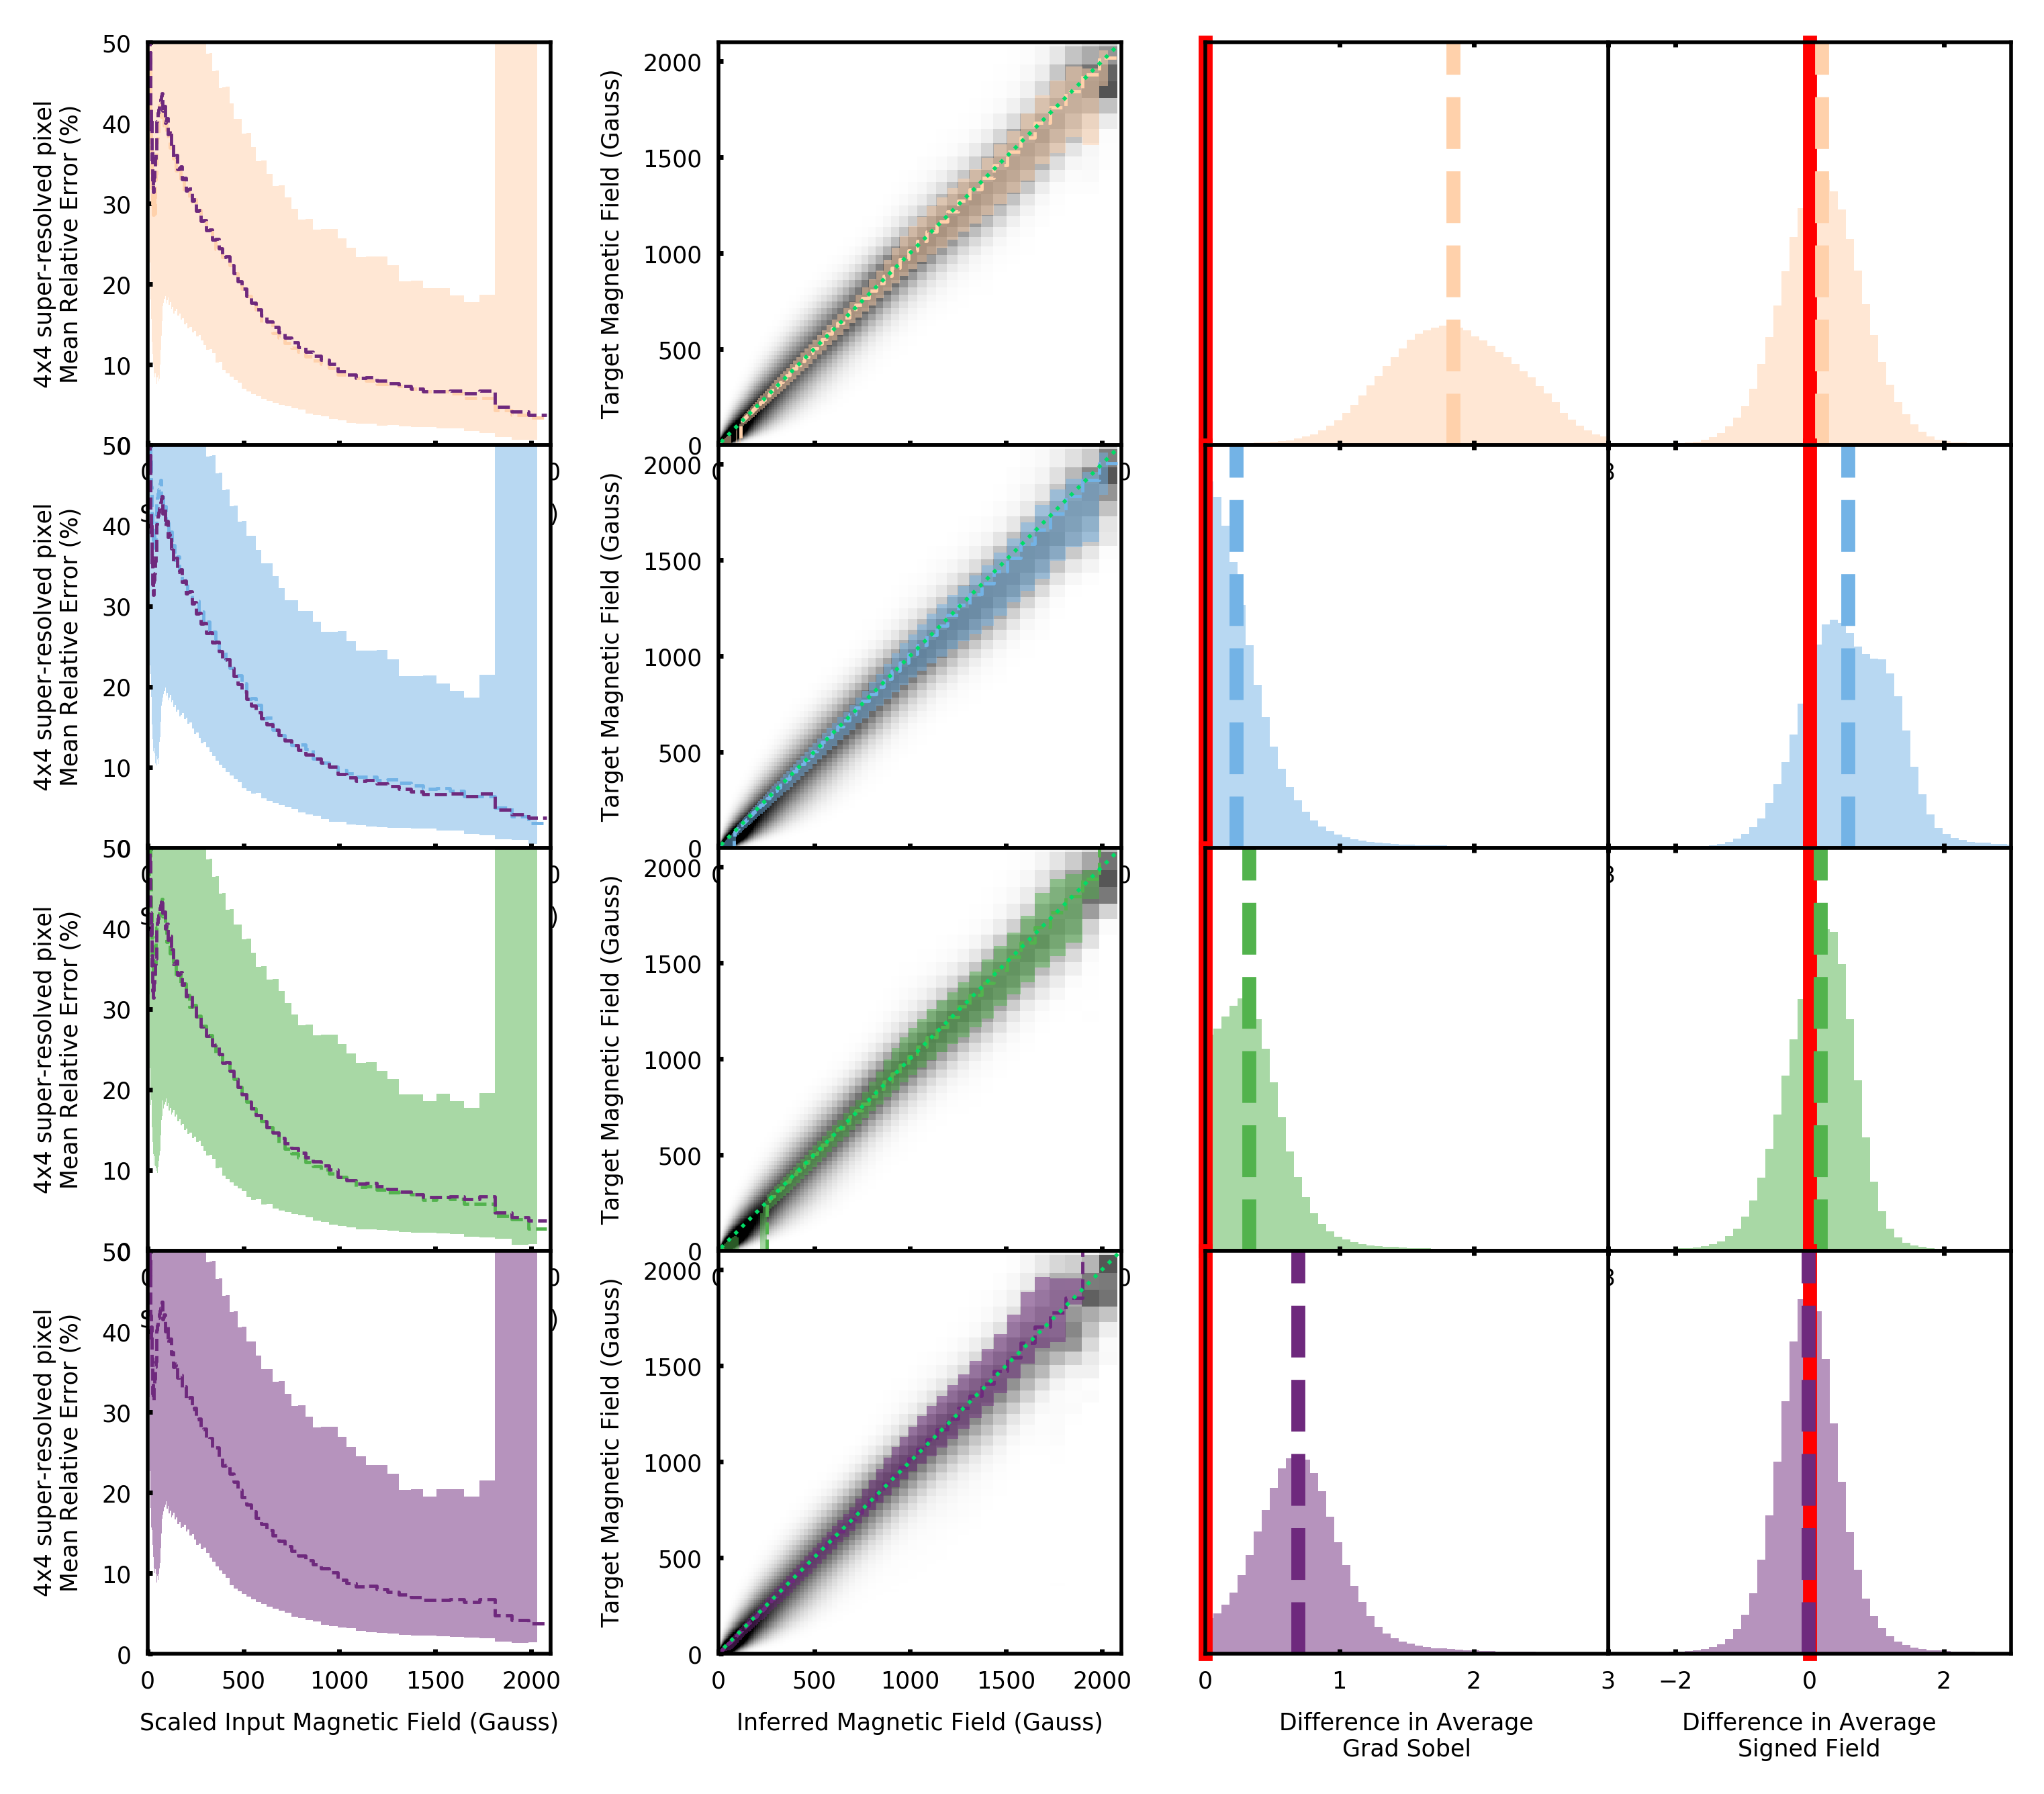

In [47]:
limit_field=2100
Cal=1

ftsz = 5

cmax = 700

ax_lim = 2100
ax_lim_er = 300

p1 = 0.05
p2 = 0.95

res_lim = 20
res_scale = 100

norm = 3500

# xs = 2000
# ys = 2000


# Size definitions
dpi = 500
pxx = 1200   # Horizontal size of each panel
pxy = 1200   # Vertical size of each panel

nph = 1     # Number of horizontal panels
npv = 2     # Number of vertical panels 

# Padding
padv  = 0  #Vertical padding in pixels
padv2 = 190  #Vertical padding in pixels between panels
padh  = 0 #Horizontal padding in pixels at the edge of the figure
padh2 = 250  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in pixels

# Conversion to relative units
ppxx   = pxx/fszh      # Horizontal size of each panel in relative units
ppxy   = pxy/fszv      # Vertical size of each panel in relative units
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)



#####   MSE --------------------------------------------------------------------------------------------------------------------------------------------------------------
##-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
##-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
##-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
##-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
##-------------------------------------------------------------------------------------------------------------------------------------------------------------------------

index = np.sum(cdf_toM_ery_abs<=0.5,axis=0)
index[index==centers.shape[0]] -= 1
median1M = centers[index]
median1M[np.abs(centers_abs)>limit_field] = np.nan

index = np.sum(cdf_toM_ery_abs<=p1,axis=0)
index[index==centers.shape[0]] -= 1
per1LM = centers[index]
per1LM[np.abs(centers_abs)>limit_field] = np.nan

index = np.sum(cdf_toM_ery_abs<=p2,axis=0)
index[index==centers.shape[0]] -= 1
per1HM = centers[index]
per1HM[np.abs(centers_abs)>limit_field] = np.nan


# Inferred
ax1M = fig.add_axes([ppadh, ppadv, ppxx/2, ppxy/2])

ax1M.pcolormesh(bins_abs,bins,norm_toMy_abs, cmap = plt.cm.get_cmap('gray_r'), vmax=0.005)
ax1M.plot(centers_abs, centers_abs+median1M, linestyle='--', label=label, color=Clr[5], linewidth=0.7, ds= 'steps-mid')
ax1M.fill_between(centers_abs/Cal, centers_abs+per1LM, centers_abs+per1HM, fc=Clr[5], alpha=0.5, ec='None', step='mid')




# ax1M.legend(frameon=False, fontsize=ftsz)
ax1M.set_ylabel('Target Magnetic Field (Gauss)', fontsize=ftsz)
ax1M.set_xlabel('Inferred Magnetic Field (Gauss)', fontsize=ftsz)
ax1M.tick_params(labelsize=ftsz, direction='in', axis='both', which='major', length=1, width=1)

ax1M.plot([-ax_lim, ax_lim], [-ax_lim, ax_lim], color='#00dd66', linestyle=':', linewidth=0.8)
ax1M.set_xlim([0, ax_lim])
ax1M.set_ylim([0, ax_lim])
# ax1M.xaxis.set_ticks_position('top')




# Inferred
ax2M = fig.add_axes([ppadh - ppxx/2-ppadh2, ppadv, ppxx/2, ppxy/2])


index = np.sum(cdf_toM_mey_abs<=0.5,axis=0)
index[index==centers.shape[0]] -= 1
median2M = centers[index]
median2M[np.abs(centers_abs)>limit_field] = np.nan

index = np.sum(cdf_toM_mey_abs<=p1,axis=0)
index[index==centers.shape[0]] -= 1
per2LM = centers[index]
per2LM[np.abs(centers_abs)>limit_field] = np.nan

index = np.sum(cdf_toM_mey_abs<=p2,axis=0)
index[index==centers.shape[0]] -= 1
per2HM = centers[index]
per2HM[np.abs(centers_abs)>limit_field] = np.nan



# ax2M.pcolor(bins,bins, norm_tiy_me, cmap = plt.cm.get_cmap('gray_r'), vmax=np.max(norm_tiy_me)*0.01)

# ax2M.plot(centers/Cal,expected/np.abs(centers/Cal)*res_scale, linestyle='-', label=label, color=Clr[2], linewidth=0.7, ds= 'steps-mid')
ax2M.plot(centers_abs, median2M/centers_abs*res_scale, linestyle='--', label=label, color=Clr[5], linewidth=0.7, ds= 'steps-mid')
ax2M.fill_between(centers_abs/Cal, per2LM/centers_abs*res_scale, per2HM/centers_abs*res_scale, fc=Clr[5], alpha=0.5, ec='None', step='mid')



# ax1M.legend(frameon=False, fontsize=ftsz)
ax2M.set_ylabel('4x4 super-resolved pixel\nMean Relative Error (%)', fontsize=ftsz)
ax2M.set_xlabel('Scaled Input Magnetic Field (Gauss)', fontsize=ftsz)
ax2M.tick_params(labelsize=ftsz, direction='in', axis='both', which='major', length=1, width=1)

ax2M.set_xlim([0, ax_lim])
ax2M.set_ylim([0, 50])
# ax1M.xaxis.set_ticks_position('top')




blim = 6.3
rlim = 0.9
varx = np.abs(diagM['UnsignedMetric_target'])*norm
lw = 3
lably = 'Difference in Average\nGrad Sobel'  
vary = np.abs(diagM['Grad_Sobel_target'] - diagM['Grad_Sobel_output'])*norm
miny = 0
maxy = 3
nbinsy = 50
binsy = np.arange(miny,maxy+(maxy-miny)/nbinsy,(maxy-miny)/nbinsy)
centersy = (binsy[1:]+binsy[0:-1])/2
xlimhp = 1.1
varyP = diagM['average_radius_input']



# Marginal y

ax3M = fig.add_axes([ppadh+ppxx/2+ppadh2/2, ppadv, ppxx/2, ppxy/2], zorder=3)

hist3M = ax3M.hist(vary[np.logical_and(varx>blim,varyP<rlim)], bins=binsy, color=Clr[5], zorder=1, alpha = 0.5)
median3M = np.nanmedian(vary[np.logical_and(varx>blim,varyP<rlim)])
xmax3 = np.max(hist3M[0])*xlimhp


if Ylabels:
    ax3M.set_xlabel(lably, fontsize=ftsz)
else:
    ax3M.set_xticklabels([])
ax3M.set_yticks([])
ax3M.set_xlim([miny, maxy])
ax3M.tick_params(direction='in', top=True, bottom=True)

ax3M.tick_params(labelsize=ftsz, direction='in', axis='both', which='major', length=1, width=1)




lably = 'Difference in Average\nSigned Field'  
vary = (diagM['SignedMetric_target'] - diagM['SignedMetric_output']) * norm
miny = -3
maxy = 3
# nbinsy = 50
binsy = np.arange(miny,maxy+(maxy-miny)/nbinsy,(maxy-miny)/nbinsy)+(maxy-miny)/nbinsy/2
centersy = (binsy[1:]+binsy[0:-1])/2



# Marginal y

ax4M = fig.add_axes([ppadh+ppxx+ppadh2/2, ppadv, ppxx/2, ppxy/2])

hist4M = ax4M.hist(vary[np.logical_and(varx>blim,varyP<rlim)], bins=binsy, color=Clr[5], zorder=1, alpha = 0.5)
median4M = np.nanmedian(vary[np.logical_and(varx>blim,varyP<rlim)])
xmax4 = np.max(hist4M[0])*xlimhp


if Ylabels:
    ax4M.set_xlabel(lably, fontsize=ftsz)
else:
    ax4M.set_xticklabels([])
ax4M.set_yticks([])
ax4M.set_xlim([miny, maxy])
ax4M.tick_params(direction='in', top=True, bottom=True)
# ax2M.set_axisbelow(False)
ax4M.tick_params(labelsize=ftsz, direction='in', axis='both', which='major', length=1, width=1)





#####   MSE + Grad --------------------------------------------------------------------------------------------------------------------------------------------------------------
##-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
##-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
##-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
##-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
##-------------------------------------------------------------------------------------------------------------------------------------------------------------------------

index = np.sum(cdf_toMG_ery_abs<=0.5,axis=0)
index[index==centers.shape[0]] -= 1
median1MG = centers[index]
median1MG[np.abs(centers_abs)>limit_field] = np.nan

index = np.sum(cdf_toMG_ery_abs<=p1,axis=0)
index[index==centers.shape[0]] -= 1
per1LMG = centers[index]
per1LMG[np.abs(centers_abs)>limit_field] = np.nan

index = np.sum(cdf_toMG_ery_abs<=p2,axis=0)
index[index==centers.shape[0]] -= 1
per1HMG = centers[index]
per1HMG[np.abs(centers_abs)>limit_field] = np.nan


# Inferred
ax1MG = fig.add_axes([ppadh, ppadv-ppxy/2, ppxx/2, ppxy/2])

ax1MG.pcolormesh(bins_abs,bins,norm_toMGy_abs, cmap = plt.cm.get_cmap('gray_r'), vmax=0.005)
ax1MG.plot(centers_abs, centers_abs+median1MG, linestyle='--', label=label, color=Clr[4], linewidth=0.7, ds= 'steps-mid')
ax1MG.fill_between(centers_abs/Cal, centers_abs+per1LMG, centers_abs+per1HMG, fc=Clr[4], alpha=0.5, ec='None', step='mid')




# ax1M.legend(frameon=False, fontsize=ftsz)
ax1MG.set_ylabel('Target Magnetic Field (Gauss)', fontsize=ftsz)
ax1MG.set_xlabel('Inferred Magnetic Field (Gauss)', fontsize=ftsz)
ax1MG.tick_params(labelsize=ftsz, direction='in', axis='both', which='major', length=1, width=1)

ax1MG.plot([-ax_lim, ax_lim], [-ax_lim, ax_lim], color='#00dd66', linestyle=':', linewidth=0.8)
ax1MG.set_xlim([0, ax_lim])
ax1MG.set_ylim([0, ax_lim])
# ax1M.xaxis.set_ticks_position('top')




# Inferred
ax2MG = fig.add_axes([ppadh - ppxx/2-ppadh2, ppadv-ppxy/2, ppxx/2, ppxy/2])


index = np.sum(cdf_toMG_mey_abs<=0.5,axis=0)
index[index==centers.shape[0]] -= 1
median2MG = centers[index]
median2MG[np.abs(centers_abs)>limit_field] = np.nan

index = np.sum(cdf_toMG_mey_abs<=p1,axis=0)
index[index==centers.shape[0]] -= 1
per2LMG = centers[index]
per2LMG[np.abs(centers_abs)>limit_field] = np.nan

index = np.sum(cdf_toMG_mey_abs<=p2,axis=0)
index[index==centers.shape[0]] -= 1
per2HMG = centers[index]
per2HMG[np.abs(centers_abs)>limit_field] = np.nan



# ax2M.pcolor(bins,bins, norm_tiy_me, cmap = plt.cm.get_cmap('gray_r'), vmax=np.max(norm_tiy_me)*0.01)

# ax2M.plot(centers/Cal,expected/np.abs(centers/Cal)*res_scale, linestyle='-', label=label, color=Clr[2], linewidth=0.7, ds= 'steps-mid')
ax2MG.plot(centers_abs, median2MG/centers_abs*res_scale, linestyle='--', label=label, color=Clr[4], linewidth=0.7, ds= 'steps-mid')
ax2MG.fill_between(centers_abs/Cal, per2LMG/centers_abs*res_scale, per2HMG/centers_abs*res_scale, fc=Clr[4], alpha=0.5, ec='None', step='mid')



# ax1M.legend(frameon=False, fontsize=ftsz)
ax2MG.set_ylabel('4x4 super-resolved pixel\nMean Relative Error (%)', fontsize=ftsz)
ax2MG.set_xlabel('Scaled Input Magnetic Field (Gauss)', fontsize=ftsz)
ax2MG.tick_params(labelsize=ftsz, direction='in', axis='both', which='major', length=1, width=1)

ax2MG.set_xlim([0, ax_lim])
ax2MG.set_ylim([0, 50])
# ax1M.xaxis.set_ticks_position('top')




blim = 6.3
rlim = 0.9
varx = np.abs(diagMG['UnsignedMetric_target'])*norm
lw = 3
lably = 'Difference in Average\nGrad Sobel'  
vary = np.abs(diagMG['Grad_Sobel_target'] - diagMG['Grad_Sobel_output'])*norm
miny = 0
maxy = 3
nbinsy = 50
binsy = np.arange(miny,maxy+(maxy-miny)/nbinsy,(maxy-miny)/nbinsy)
centersy = (binsy[1:]+binsy[0:-1])/2
xlimhp = 1.1
varyP = diagMG['average_radius_input']



# Marginal y

ax3MG = fig.add_axes([ppadh+ppxx/2+ppadh2/2, ppadv-ppxy/2, ppxx/2, ppxy/2], zorder=3)

hist3MG = ax3MG.hist(vary[np.logical_and(varx>blim,varyP<rlim)], bins=binsy, color=Clr[4], zorder=1, alpha = 0.5)
median3MG = np.nanmedian(vary[np.logical_and(varx>blim,varyP<rlim)])
xmax3 = np.max([xmax3, np.max(hist3MG[0])*xlimhp])


if Ylabels:
    ax3MG.set_xlabel(lably, fontsize=ftsz)
else:
    ax3MG.set_xticklabels([])
ax3MG.set_yticks([])
ax3MG.set_xlim([miny, maxy])
ax3MG.tick_params(direction='in', top=True, bottom=True)

ax3MG.tick_params(labelsize=ftsz, direction='in', axis='both', which='major', length=1, width=1)




lably = 'Difference in Average\nSigned Field'  
vary = (diagMG['SignedMetric_target'] - diagMG['SignedMetric_output']) * norm
miny = -3
maxy = 3
# nbinsy = 50
binsy = np.arange(miny,maxy+(maxy-miny)/nbinsy,(maxy-miny)/nbinsy)+(maxy-miny)/nbinsy/2
centersy = (binsy[1:]+binsy[0:-1])/2



# Marginal y

ax4MG = fig.add_axes([ppadh+ppxx+ppadh2/2, ppadv-ppxy/2, ppxx/2, ppxy/2])

hist4MG = ax4MG.hist(vary[np.logical_and(varx>blim,varyP<rlim)], bins=binsy, color=Clr[4], zorder=1, alpha = 0.5)
median4MG = np.nanmedian(vary[np.logical_and(varx>blim,varyP<rlim)])
xmax4 = np.max([xmax4, np.max(hist4MG[0])*xlimhp])


if Ylabels:
    ax4MG.set_xlabel(lably, fontsize=ftsz)
else:
    ax4MG.set_xticklabels([])
ax4MG.set_yticks([])
ax4MG.set_xlim([miny, maxy])
ax4MG.tick_params(direction='in', top=True, bottom=True)
# ax2M.set_axisbelow(False)
ax4MG.tick_params(labelsize=ftsz, direction='in', axis='both', which='major', length=1, width=1)






#####   MSE + Grad + Hist --------------------------------------------------------------------------------------------------------------------------------------------------------------
##-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
##-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
##-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
##-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
##-------------------------------------------------------------------------------------------------------------------------------------------------------------------------

index = np.sum(cdf_toMGH_ery_abs<=0.5,axis=0)
index[index==centers.shape[0]] -= 1
median1MGH = centers[index]
median1MGH[np.abs(centers_abs)>limit_field] = np.nan

index = np.sum(cdf_toMGH_ery_abs<=p1,axis=0)
index[index==centers.shape[0]] -= 1
per1LMGH = centers[index]
per1LMGH[np.abs(centers_abs)>limit_field] = np.nan

index = np.sum(cdf_toMGH_ery_abs<=p2,axis=0)
index[index==centers.shape[0]] -= 1
per1HMGH = centers[index]
per1HMGH[np.abs(centers_abs)>limit_field] = np.nan


# Inferred
ax1MGH = fig.add_axes([ppadh, ppadv-2*ppxy/2, ppxx/2, ppxy/2])

ax1MGH.pcolormesh(bins_abs,bins,norm_toMGHy_abs, cmap = plt.cm.get_cmap('gray_r'), vmax=0.005)
ax1MGH.plot(centers_abs, centers_abs+median1MGH, linestyle='--', label=label, color=Clr[3], linewidth=0.7, ds= 'steps-mid')
ax1MGH.fill_between(centers_abs/Cal, centers_abs+per1LMGH, centers_abs+per1HMGH, fc=Clr[3], alpha=0.5, ec='None', step='mid')




# ax1M.legend(frameon=False, fontsize=ftsz)
ax1MGH.set_ylabel('Target Magnetic Field (Gauss)', fontsize=ftsz)
ax1MGH.set_xlabel('Inferred Magnetic Field (Gauss)', fontsize=ftsz)
ax1MGH.tick_params(labelsize=ftsz, direction='in', axis='both', which='major', length=1, width=1)

ax1MGH.plot([-ax_lim, ax_lim], [-ax_lim, ax_lim], color='#00dd66', linestyle=':', linewidth=0.8)
ax1MGH.set_xlim([0, ax_lim])
ax1MGH.set_ylim([0, ax_lim])
# ax1M.xaxis.set_ticks_position('top')




# Inferred
ax2MGH = fig.add_axes([ppadh - ppxx/2-ppadh2, ppadv-2*ppxy/2, ppxx/2, ppxy/2])


index = np.sum(cdf_toMGH_mey_abs<=0.5,axis=0)
index[index==centers.shape[0]] -= 1
median2MGH = centers[index]
median2MGH[np.abs(centers_abs)>limit_field] = np.nan

index = np.sum(cdf_toMGH_mey_abs<=p1,axis=0)
index[index==centers.shape[0]] -= 1
per2LMGH = centers[index]
per2LMGH[np.abs(centers_abs)>limit_field] = np.nan

index = np.sum(cdf_toMGH_mey_abs<=p2,axis=0)
index[index==centers.shape[0]] -= 1
per2HMGH = centers[index]
per2HMGH[np.abs(centers_abs)>limit_field] = np.nan



# ax2M.pcolor(bins,bins, norm_tiy_me, cmap = plt.cm.get_cmap('gray_r'), vmax=np.max(norm_tiy_me)*0.01)

# ax2M.plot(centers/Cal,expected/np.abs(centers/Cal)*res_scale, linestyle='-', label=label, color=Clr[2], linewidth=0.7, ds= 'steps-mid')
ax2MGH.plot(centers_abs, median2MGH/centers_abs*res_scale, linestyle='--', label=label, color=Clr[3], linewidth=0.7, ds= 'steps-mid')
ax2MGH.fill_between(centers_abs/Cal, per2LMGH/centers_abs*res_scale, per2HMGH/centers_abs*res_scale, fc=Clr[3], alpha=0.5, ec='None', step='mid')



# ax1M.legend(frameon=False, fontsize=ftsz)
ax2MGH.set_ylabel('4x4 super-resolved pixel\nMean Relative Error (%)', fontsize=ftsz)
ax2MGH.set_xlabel('Scaled Input Magnetic Field (Gauss)', fontsize=ftsz)
ax2MGH.tick_params(labelsize=ftsz, direction='in', axis='both', which='major', length=1, width=1)

ax2MGH.set_xlim([0, ax_lim])
ax2MGH.set_ylim([0, 50])
# ax1M.xaxis.set_ticks_position('top')




blim = 6.3
rlim = 0.9
varx = np.abs(diagMGH['UnsignedMetric_target'])*norm
lw = 3
lably = 'Difference in Average\nGrad Sobel'  
vary = np.abs(diagMGH['Grad_Sobel_target'] - diagMGH['Grad_Sobel_output'])*norm
miny = 0
maxy = 3
nbinsy = 50
binsy = np.arange(miny,maxy+(maxy-miny)/nbinsy,(maxy-miny)/nbinsy)
centersy = (binsy[1:]+binsy[0:-1])/2
xlimhp = 1.1
varyP = diagMGH['average_radius_input']



# Marginal y

ax3MGH = fig.add_axes([ppadh+ppxx/2+ppadh2/2, ppadv-2*ppxy/2, ppxx/2, ppxy/2], zorder=3)

hist3MGH = ax3MGH.hist(vary[np.logical_and(varx>blim,varyP<rlim)], bins=binsy, color=Clr[3], zorder=1, alpha = 0.5)
median3MGH = np.nanmedian(vary[np.logical_and(varx>blim,varyP<rlim)])
xmax3 = np.max([xmax3, np.max(hist3MGH[0])*xlimhp])


if Ylabels:
    ax3MGH.set_xlabel(lably, fontsize=ftsz)
else:
    ax3MGH.set_xticklabels([])
ax3MGH.set_yticks([])
ax3MGH.set_xlim([miny, maxy])
ax3MGH.tick_params(direction='in', top=True, bottom=True)

ax3MGH.tick_params(labelsize=ftsz, direction='in', axis='both', which='major', length=1, width=1)




lably = 'Difference in Average\nSigned Field'  
vary = (diagMGH['SignedMetric_target'] - diagMGH['SignedMetric_output']) * norm
miny = -3
maxy = 3
# nbinsy = 50
binsy = np.arange(miny,maxy+(maxy-miny)/nbinsy,(maxy-miny)/nbinsy)+(maxy-miny)/nbinsy/2
centersy = (binsy[1:]+binsy[0:-1])/2



# Marginal y

ax4MGH = fig.add_axes([ppadh+ppxx+ppadh2/2, ppadv-2*ppxy/2, ppxx/2, ppxy/2])

hist4MGH = ax4MGH.hist(vary[np.logical_and(varx>blim,varyP<rlim)], bins=binsy, color=Clr[3], zorder=1, alpha = 0.5)
median4MGH = np.nanmedian(vary[np.logical_and(varx>blim,varyP<rlim)])
xmax4 = np.max([xmax4, np.max(hist4MGH[0])*xlimhp])


if Ylabels:
    ax4MGH.set_xlabel(lably, fontsize=ftsz)
else:
    ax4MGH.set_xticklabels([])
ax4MGH.set_yticks([])
ax4MGH.set_xlim([miny, maxy])
ax4MGH.tick_params(direction='in', top=True, bottom=True)
# ax2M.set_axisbelow(False)
ax4MGH.tick_params(labelsize=ftsz, direction='in', axis='both', which='major', length=1, width=1)




#####   MSE + Grad + Hist + SSIM --------------------------------------------------------------------------------------------------------------------------------------------------------------
##-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
##-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
##-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
##-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
##-------------------------------------------------------------------------------------------------------------------------------------------------------------------------

index = np.sum(cdf_toMGHS_ery_abs<=0.5,axis=0)
index[index==centers.shape[0]] -= 1
median1MGHS = centers[index]
median1MGHS[np.abs(centers_abs)>limit_field] = np.nan

index = np.sum(cdf_toMGHS_ery_abs<=p1,axis=0)
index[index==centers.shape[0]] -= 1
per1LMGHS = centers[index]
per1LMGHS[np.abs(centers_abs)>limit_field] = np.nan

index = np.sum(cdf_toMGHS_ery_abs<=p2,axis=0)
index[index==centers.shape[0]] -= 1
per1HMGHS = centers[index]
per1HMGHS[np.abs(centers_abs)>limit_field] = np.nan


# Inferred
ax1MGHS = fig.add_axes([ppadh, ppadv-3*ppxy/2, ppxx/2, ppxy/2])

ax1MGHS.pcolormesh(bins_abs,bins,norm_toMGHSy_abs, cmap = plt.cm.get_cmap('gray_r'), vmax=0.005)
ax1MGHS.plot(centers_abs, centers_abs+median1MGHS, linestyle='--', label=label, color=Clr[2], linewidth=0.7, ds= 'steps-mid')
ax1MGHS.fill_between(centers_abs/Cal, centers_abs+per1LMGHS, centers_abs+per1HMGHS, fc=Clr[2], alpha=0.5, ec='None', step='mid')




# ax1M.legend(frameon=False, fontsize=ftsz)
ax1MGHS.set_ylabel('Target Magnetic Field (Gauss)', fontsize=ftsz)
ax1MGHS.set_xlabel('Inferred Magnetic Field (Gauss)', fontsize=ftsz)
ax1MGHS.tick_params(labelsize=ftsz, direction='in', axis='both', which='major', length=1, width=1)

ax1MGHS.plot([-ax_lim, ax_lim], [-ax_lim, ax_lim], color='#00dd66', linestyle=':', linewidth=0.8)
ax1MGHS.set_xlim([0, ax_lim])
ax1MGHS.set_ylim([0, ax_lim])
# ax1M.xaxis.set_ticks_position('top')




# Inferred
ax2MGHS = fig.add_axes([ppadh - ppxx/2-ppadh2, ppadv-3*ppxy/2, ppxx/2, ppxy/2])


index = np.sum(cdf_toMGHS_mey_abs<=0.5,axis=0)
index[index==centers.shape[0]] -= 1
median2MGHS = centers[index]
median2MGHS[np.abs(centers_abs)>limit_field] = np.nan

index = np.sum(cdf_toMGHS_mey_abs<=p1,axis=0)
index[index==centers.shape[0]] -= 1
per2LMGHS = centers[index]
per2LMGHS[np.abs(centers_abs)>limit_field] = np.nan

index = np.sum(cdf_toMGHS_mey_abs<=p2,axis=0)
index[index==centers.shape[0]] -= 1
per2HMGHS = centers[index]
per2HMGHS[np.abs(centers_abs)>limit_field] = np.nan



# ax2M.pcolor(bins,bins, norm_tiy_me, cmap = plt.cm.get_cmap('gray_r'), vmax=np.max(norm_tiy_me)*0.01)

# ax2M.plot(centers/Cal,expected/np.abs(centers/Cal)*res_scale, linestyle='-', label=label, color=Clr[2], linewidth=0.7, ds= 'steps-mid')
ax2MGHS.plot(centers_abs, median2MGHS/centers_abs*res_scale, linestyle='--', label=label, color=Clr[2], linewidth=0.7, ds= 'steps-mid')
ax2MGHS.fill_between(centers_abs/Cal, per2LMGHS/centers_abs*res_scale, per2HMGHS/centers_abs*res_scale, fc=Clr[2], alpha=0.5, ec='None', step='mid')



# ax1M.legend(frameon=False, fontsize=ftsz)
ax2MGHS.set_ylabel('4x4 super-resolved pixel\nMean Relative Error (%)', fontsize=ftsz)
ax2MGHS.set_xlabel('Scaled Input Magnetic Field (Gauss)', fontsize=ftsz)
ax2MGHS.tick_params(labelsize=ftsz, direction='in', axis='both', which='major', length=1, width=1)

ax2MGHS.set_xlim([0, ax_lim])
ax2MGHS.set_ylim([0, 50])
# ax1M.xaxis.set_ticks_position('top')




blim = 6.3
rlim = 0.9
varx = np.abs(diagMGHS['UnsignedMetric_target'])*norm
lw = 3
lably = 'Difference in Average\nGrad Sobel'  
vary = np.abs(diagMGHS['Grad_Sobel_target'] - diagMGHS['Grad_Sobel_output'])*norm
miny = 0
maxy = 3
nbinsy = 50
binsy = np.arange(miny,maxy+(maxy-miny)/nbinsy,(maxy-miny)/nbinsy)
centersy = (binsy[1:]+binsy[0:-1])/2
xlimhp = 1.1
varyP = diagMGHS['average_radius_input']



# Marginal y

ax3MGHS = fig.add_axes([ppadh+ppxx/2+ppadh2/2, ppadv-3*ppxy/2, ppxx/2, ppxy/2], zorder=3)

hist3MGHS = ax3MGHS.hist(vary[np.logical_and(varx>blim,varyP<rlim)], bins=binsy, color=Clr[2], zorder=1, alpha = 0.5)
median3MGHS = np.nanmedian(vary[np.logical_and(varx>blim,varyP<rlim)])
xmax3 = np.max([xmax3, np.max(hist3MGHS[0])*xlimhp])


if Ylabels:
    ax3MGHS.set_xlabel(lably, fontsize=ftsz)
else:
    ax3MGHS.set_xticklabels([])
ax3MGHS.set_yticks([])
ax3MGHS.set_xlim([miny, maxy])
ax3MGHS.tick_params(direction='in', top=True, bottom=True)

ax3MGHS.tick_params(labelsize=ftsz, direction='in', axis='both', which='major', length=1, width=1)




lably = 'Difference in Average\nSigned Field'  
vary = (diagMGHS['SignedMetric_target'] - diagMGHS['SignedMetric_output']) * norm
miny = -3
maxy = 3
# nbinsy = 50
binsy = np.arange(miny,maxy+(maxy-miny)/nbinsy,(maxy-miny)/nbinsy)+(maxy-miny)/nbinsy/2
centersy = (binsy[1:]+binsy[0:-1])/2



# Marginal y

ax4MGHS = fig.add_axes([ppadh+ppxx+ppadh2/2, ppadv-3*ppxy/2, ppxx/2, ppxy/2])

hist4MGHS = ax4MGHS.hist(vary[np.logical_and(varx>blim,varyP<rlim)], bins=binsy, color=Clr[2], zorder=1, alpha = 0.5)
median4MGHS = np.nanmedian(vary[np.logical_and(varx>blim,varyP<rlim)])
xmax4 = np.max([xmax4, np.max(hist4MGHS[0])*xlimhp])


if Ylabels:
    ax4MGHS.set_xlabel(lably, fontsize=ftsz)
else:
    ax4MGHS.set_xticklabels([])
ax4MGHS.set_yticks([])
ax4MGHS.set_xlim([miny, maxy])
ax4MGHS.tick_params(direction='in', top=True, bottom=True)
# ax2M.set_axisbelow(False)
ax4MGHS.tick_params(labelsize=ftsz, direction='in', axis='both', which='major', length=1, width=1)











# ####   Bicubic --------------------------------------------------------------------------------------------------------------------------






# Cal = 1.3
# Cal = 0.67

# Cal=1
# # Cal=1.90

# index = np.sum(cdf_ti_ery<=0.5,axis=0)
# index[index==centers.shape[1]] -= 1
# median1M = centers[index]
# median1M[np.abs(centers)>limit_field] = np.nan


# index = np.sum(cdf_ti_ery<=p1,axis=0)
# index[index==centers.shape[1]] -= 1
# per1LM = centers[index]
# per1LM[np.abs(centers)>limit_field] = np.nan

# index = np.sum(cdf_ti_ery<=p2,axis=0)
# index[index==centers.shape[1]] -= 1
# per1HM = centers[index]
# per1HM[np.abs(centers)>limit_field] = np.nan

# ax2M = fig.add_axes([ppadh, ppadv+ppxy/2, ppxx/2, ppxy/2])

# ax2M.pcolormesh(bins/Cal,bins,norm_tiy, cmap = plt.cm.get_cmap('gray_r'), vmax=0.005)

# ax2M.plot(centers/Cal,centers/Cal+median1M/Cal, linestyle='-', label=label, color=Clr[2], linewidth=0.7, ds= 'steps-mid')
# ax2M.fill_between(centers/Cal, centers/Cal+per1LM/Cal, centers/Cal+per1HM/Cal, fc=Clr[2], alpha=0.5, ec='None', step='mid')

# ax2M.tick_params(labelsize=ftsz, direction='in', axis='both', which='major', length=1, width=1)

# ax2M.set_ylabel('Target Magnetic Field (Gauss)', fontsize=ftsz)
# ax2M.set_xlabel('Inferred Magnetic Field (Gauss)', fontsize=ftsz)
# ax2M.plot([-ax_lim, ax_lim], [-ax_lim, ax_lim], color='#00dd66', linestyle=':', linewidth=0.8)
# # ax2M.yaxis.tick_right()
# # ax2M.yaxis.set_label_position("right")
# # ax2M.set_title('MDI to HMI\nBicubic/1.3 (Scaled)', fontsize=ftsz)
# # ax2M.set_xlim([-ax_lim, ax_lim])
# # ax2M.set_ylim([-ax_lim, ax_lim])
# ax2M.set_xlim([0, ax_lim])
# ax2M.set_ylim([0, ax_lim])
# # ax2M.xaxis.set_ticks_position('top')
# ax2M.xaxis.set_ticks_position('top')
# ax2M.xaxis.set_label_position('top') 




# # Inferred
# ax3M = fig.add_axes([ppadh - ppxx/2-ppadh2, ppadv+ppxy/2, ppxx/2, ppxy/2])



# # ax5.pcolor(bins,bins, norm_tiy_me, cmap = plt.cm.get_cmap('gray_r'), vmax=np.max(norm_tiy_me)*0.01)

# expected = np.nansum(np.repeat(widths[:,None],norm_ti_me.shape[0],axis=1)*np.repeat(centers[:,None],norm_ti_me.shape[0],axis=1)*norm_ti_me, axis=0)/np.nansum(np.repeat(widths[:,None],norm_ti_me.shape[0],axis=1)*norm_ti_me, axis=0)
# ax3M.plot(centers/Cal,expected/np.abs(centers/Cal)*res_scale, linestyle='-', label=label, color=Clr[2], linewidth=0.7, ds= 'steps-mid')

# variance = np.nansum(np.repeat(widths[:,None],norm_ti_me.shape[0],axis=1)*(np.repeat(centers[:,None],norm_ti_me.shape[0],axis=1) - np.repeat(expected[None],norm_ti_me.shape[0],axis=0))**2*norm_ti_me, axis=0)/np.nansum(np.repeat(widths[:,None],norm_ti_me.shape[0],axis=1)*norm_ti_me, axis=0)
# variance = np.sqrt(variance)
# ax3M.fill_between(centers/Cal, (expected-variance)/np.abs(centers/Cal)*res_scale, (expected+variance)/np.abs(centers/Cal)*res_scale, fc=Clr[2], alpha=0.5, ec='None', step='mid')



# # ax5.pcolor(bins,bins, norm_toMy_me, cmap = plt.cm.get_cmap('gray_r'), vmax=np.max(norm_toMy_me)*0.01)

# # expected = np.nansum(np.repeat(widths[:,None],norm_toM_me.shape[0],axis=1)*np.repeat(centers[:,None],norm_toM_me.shape[0],axis=1)*norm_toM_me, axis=0)/np.nansum(np.repeat(widths[:,None],norm_toM_me.shape[0],axis=1)*norm_toM_me, axis=0)
# # ax5.plot(centers/Cal,expected/np.abs(centers/Cal)*res_scale, linestyle='--', label=label, color=Clr[5], linewidth=0.7, ds= 'steps-mid')

# # variance = np.nansum(np.repeat(widths[:,None],norm_toM_me.shape[0],axis=1)*(np.repeat(centers[:,None],norm_toM_me.shape[0],axis=1) - np.repeat(expected[None],norm_toM_me.shape[0],axis=0))**2*norm_toM_me, axis=0)/np.nansum(np.repeat(widths[:,None],norm_toM_me.shape[0],axis=1)*norm_toM_me, axis=0)
# # variance = np.sqrt(variance)
# # ax5.fill_between(centers/Cal, (expected-variance)/np.abs(centers/Cal)*res_scale, (expected+variance)/np.abs(centers/Cal)*res_scale, fc=Clr[5], alpha=0.5, ec='None', step='mid')



# # ax1M.legend(frameon=False, fontsize=ftsz)
# ax3M.set_ylabel('4x4 super-resolved pixel\nMean Relative Error (%)', fontsize=ftsz)
# ax3M.set_xlabel('Scaled Input Magnetic Field (Gauss)', fontsize=ftsz)
# ax3M.tick_params(labelsize=ftsz, direction='in', axis='both', which='major', length=1, width=1)

# # ax5.plot([-ax_lim, ax_lim], [-ax_lim, ax_lim], color='#00dd66', linestyle=':', linewidth=0.8)
# # ax1M.set_title(label, fontsize=ftsz)
# # ax1M.set_title(label, fontsize=ftsz)
# # ax5.set_title('GONG to HMI\nMSE + SSIM + HIST + GRAD', fontsize=ftsz)
# # ax5.set_xlim([-ax_lim, ax_lim])
# ax3M.set_xlim([0, ax_lim])
# ax3M.set_ylim([0, 50])
# ax3M.xaxis.set_ticks_position('top')
# ax3M.xaxis.set_label_position('top') 




#####   Common Elements --------------------------------------------------------------------------------------------------------------------------------------------------------------
##-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
##-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
##-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
##-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
##-------------------------------------------------------------------------------------------------------------------------------------------------------------------------

ax3M.set_ylim([0, xmax3])
ax3M.plot([0, 0], [0, xmax3], color='r', zorder=2, lw=lw, clip_on=False)
ax3M.plot([median3M, median3M], [0, xmax3], color=Clr[5], zorder=2, ls='--', lw=lw)

ax4M.set_ylim([0, xmax4])
ax4M.plot([0, 0], [0, xmax4], color='r', zorder=2, lw=lw, clip_on=False)
ax4M.plot([median4M, median4M], [0, xmax4], color=Clr[5], zorder=2, ls='--', lw=lw)



ax3MG.set_ylim([0, xmax3])
ax3MG.plot([0, 0], [0, xmax3], color='r', zorder=2, lw=lw, clip_on=False)
ax3MG.plot([median3MG, median3MG], [0, xmax3], color=Clr[4], zorder=2, ls='--', lw=lw)

ax4MG.set_ylim([0, xmax4])
ax4MG.plot([0, 0], [0, xmax4], color='r', zorder=2, lw=lw, clip_on=False)
ax4MG.plot([median4MG, median4MG], [0, xmax4], color=Clr[4], zorder=2, ls='--', lw=lw)



ax3MGH.set_ylim([0, xmax3])
ax3MGH.plot([0, 0], [0, xmax3], color='r', zorder=2, lw=lw, clip_on=False)
ax3MGH.plot([median3MGH, median3MGH], [0, xmax3], color=Clr[3], zorder=2, ls='--', lw=lw)

ax4MGH.set_ylim([0, xmax4])
ax4MGH.plot([0, 0], [0, xmax4], color='r', zorder=2, lw=lw, clip_on=False)
ax4MGH.plot([median4MGH, median4MGH], [0, xmax4], color=Clr[3], zorder=2, ls='--', lw=lw)



ax3MGHS.set_ylim([0, xmax3])
ax3MGHS.plot([0, 0], [0, xmax3], color='r', zorder=2, lw=lw, clip_on=False)
ax3MGHS.plot([median3MGHS, median3MGHS], [0, xmax3], color=Clr[2], zorder=2, ls='--', lw=lw)

ax4MGHS.set_ylim([0, xmax4])
ax4MGHS.plot([0, 0], [0, xmax4], color='r', zorder=2, lw=lw, clip_on=False)
ax4MGHS.plot([median4MGHS, median4MGHS], [0, xmax4], color=Clr[2], zorder=2, ls='--', lw=lw)

ax2MGH.plot(centers_abs, median2MGHS/centers_abs*res_scale, linestyle='--', label=label, color=Clr[2], linewidth=0.7, ds= 'steps-mid')
ax2MG.plot(centers_abs, median2MGHS/centers_abs*res_scale, linestyle='--', label=label, color=Clr[2], linewidth=0.7, ds= 'steps-mid')
ax2M.plot(centers_abs, median2MGHS/centers_abs*res_scale, linestyle='--', label=label, color=Clr[2], linewidth=0.7, ds= 'steps-mid')

